<a href="https://colab.research.google.com/github/HarshitaMBharadwaj/Net_Worth/blob/main/NBA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import requests
import csv
import pandas as pd
from google.colab import files
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from bs4 import BeautifulSoup
from google.colab import drive
drive.mount('/content/drive')
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from pandas import Series

Mounted at /content/drive


# Webscraping Data

## Scraping Players Stats Data

In [2]:
api_url = "https://api-nba-v1.p.rapidapi.com/"
headers = {
	"X-RapidAPI-Key": "37aa8ec10dmsh132eab725928607p1d5335jsnb00e614463b7",
	"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
}

In [11]:
print(data.keys())

endpoint = "players/statistics"
querystring = {"id":"236","season":"2020"}

url = api_url + endpoint


response = requests.get(url, headers=headers, params=querystring)

data = response.json()
print(data.keys())
df = pd.DataFrame(data["response"])
df = df.drop(['game', 'comment', 'min'], axis=1)
pd.set_option('display.max_columns', None)

print(df.head())

dict_keys(['message'])
Error: 403


In [12]:
def playerids_retriever(season):


    url = "https://api-nba-v1.p.rapidapi.com/players"
    headers = {
        "X-RapidAPI-Key": "37aa8ec10dmsh132eab725928607p1d5335jsnb00e614463b7",
        "X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
    }


    player_ids = []


    for team_id in range(1, 32):
        querystring = {"team": str(team_id), "season": season}
        response = requests.get(url, headers=headers, params=querystring)

        if response.status_code == 200:
            data = response.json()

            team_player_ids = [player['id'] for player in data['response']]

            player_ids.extend(team_player_ids)
        else:
            print(f"Failed to fetch data for team ID {team_id}: {response.status_code}")

    return player_ids

In [13]:
def aggregate_season_stats(player_ids, season, headers):

    all_players_stats = pd.DataFrame()

    for player_id in player_ids:
        endpoint = "players/statistics"
        querystring = {"id": str(player_id), "season": str(season)}
        url = api_url + endpoint

        response = requests.get(url, headers=headers, params=querystring)

        if response.status_code == 200:
            player_data = response.json()


            player_stats = pd.json_normalize(player_data['response'], sep='_')


            all_players_stats = pd.concat([all_players_stats, player_stats], ignore_index=True)
        else:
            print(f"Failed to fetch data for player ID {player_id}: {response.status_code}")


    columns_of_interest = ['player_id', 'player_firstname', 'player_lastname', 'pos',
                           'points', 'fgm', 'fga', 'fgp', 'ftm', 'fta', 'ftp',
                           'tpm', 'tpa', 'tpp', 'offReb', 'defReb', 'totReb',
                           'assists', 'pFouls', 'steals', 'turnovers', 'blocks', 'plusMinus']
    all_players_stats = all_players_stats[all_players_stats.columns.intersection(columns_of_interest)]


    stats_columns = ['points', 'fgm', 'fga', 'fgp', 'ftm', 'fta', 'ftp',
                     'tpm', 'tpa', 'tpp', 'offReb', 'defReb', 'totReb',
                     'assists', 'pFouls', 'steals', 'turnovers', 'blocks', 'plusMinus']
    all_players_stats[stats_columns] = all_players_stats[stats_columns].apply(pd.to_numeric, errors='coerce')


    aggregated_stats = all_players_stats.groupby(['player_id', 'player_firstname', 'player_lastname', 'pos'], as_index=False).sum()

    return aggregated_stats

In [14]:
def aggregate_season_stats(player_ids, season, headers):
    all_players_stats_list = []

    for player_id in player_ids:
        endpoint = "players/statistics"
        querystring = {"id": str(player_id), "season": str(season)}
        url = api_url + endpoint

        response = requests.get(url, headers=headers, params=querystring)

        if response.status_code == 200:
            player_data = response.json()
            player_stats = pd.json_normalize(player_data['response'], sep='_')


            common_columns = set(player_stats.columns) & set([
                'player_id', 'player_firstname', 'player_lastname', 'team_id', 'team_name',
                'team_nickname', 'team_code', 'team_logo', 'game_id', 'points', 'pos',
                'min', 'fgm', 'fga', 'fgp', 'ftm', 'fta', 'ftp', 'tpm', 'tpa', 'tpp',
                'offReb', 'defReb', 'totReb', 'assists', 'pFouls', 'steals', 'turnovers',
                'blocks', 'plusMinus'
            ])
            player_stats = player_stats[list(common_columns)]

            all_players_stats_list.append(player_stats)
        else:
            print(f"Failed to fetch data for player ID {player_id}: {response.status_code}")


    all_players_stats = pd.concat(all_players_stats_list, ignore_index=True) if all_players_stats_list else pd.DataFrame()


    stats_columns = [
        'points', 'fgm', 'fga', 'ftm', 'fta', 'tpm', 'tpa',
        'offReb', 'defReb', 'totReb', 'assists', 'pFouls', 'steals',
        'turnovers', 'blocks', 'plusMinus'
    ]
    all_players_stats[stats_columns] = all_players_stats[stats_columns].apply(pd.to_numeric, errors='coerce')


    aggregated_stats = all_players_stats.groupby(
        ['player_id', 'player_firstname', 'player_lastname', 'pos'], as_index=False
    ).sum()

    return aggregated_stats


In [15]:
def export_season_stats(season):


    player_ids = playerids_retriever(season)


    season_stats_df = aggregate_season_stats(player_ids, season, headers)

    print("Preview of the df")
    print(season_stats_df.head())
    print("\n")
    print(season_stats_df.info())
    print("\n")
    print(season_stats_df.describe())

    csv_file_path = f'season_{season}_player_stats.csv'


    season_stats_df.to_csv(csv_file_path, index=False)
    print(f"Season {season} statistics has been exported.")


    files.download(csv_file_path)

In [17]:
export_season_stats('2023')

In [19]:
export_season_stats('2022')

In [ ]:
export_season_stats('2021')

In [21]:
for year in range(2020, 2008, -1):
    export_season_stats(str(year))

## Scraping the Players Salaries Data

In [ ]:

seasons = ["2015-2016", "2016-2017", "2017-2018", "2018-2019", "2019-2020",
           "2020-2021", "2021-2022", "2022-2023", "2023-2024"]


base_url = "https://hoopshype.com/salaries/players/"

def scrape_salaries(season):

    url = base_url if season == "2023-2024" else f"{base_url}{season}/"
    response = requests.get(url)


    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'class': 'hh-salaries-ranking-table'})
        rows = table.find_all('tr') if table else []
        data = []

        for row in rows:
            columns = row.find_all('td')

            if columns and len(columns) > 2:
                player_name = columns[1].get_text(strip=True)
                salary = columns[2].get_text(strip=True)
                data.append({"Year": season.split('-')[0], "Player": player_name, "Salary": salary})
        return data
    else:
        print(f"Failed to retrieve data for season {season}")
        return []


for season in seasons:
    season_data = scrape_salaries(season)
    df = pd.DataFrame(season_data)
    csv_file = f"nba_salaries_{season.split('-')[0]}.csv"
    df.to_csv(csv_file, index=False)
    print(f"Data for {season} saved to {csv_file}")


#Exploratory Data Analysis

In [ ]:
player_stat2015 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2015_player_stats.csv')
player_stat2016 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2016_player_stats.csv')
player_stat2017 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2017_player_stats.csv')
player_stat2018 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2018_player_stats.csv')
player_stat2019 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2019_player_stats.csv')
player_stat2020 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2020_player_stats.csv')
player_stat2021 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2021_player_stats.csv')
player_stat2022 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2022_player_stats.csv')
player_stat2023 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/season_2023_player_stats.csv')
player_sal2015 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2015.csv')
player_sal2016 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2016.csv')
player_sal2017 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2017.csv')
player_sal2018 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2018.csv')
player_sal2019 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2019.csv')
player_sal2020 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2020.csv')
player_sal2021 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2021.csv')
player_sal2022 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2022.csv')
player_sal2023 = pd.read_csv('/content/drive/My Drive/NBA-Project/Data/nba_salaries_2023.csv')

In [ ]:
player_stat2015.columns

Index(['player_id', 'player_firstname', 'player_lastname', 'pos', 'fga',
       'defReb', 'fgm', 'tpm', 'totReb', 'offReb', 'turnovers', 'fta',
       'pFouls', 'assists', 'points', 'game_id', 'steals', 'team_id',
       'plusMinus', 'ftm', 'tpa', 'blocks'],
      dtype='object')

## Cleaning the Player Stats

In [ ]:
def cleanplayerstats(player_stat):

  def clean_and_concatenate(first_name, last_name):
    clean_first_name = re.sub(r'\W+', ' ', first_name).strip()
    clean_last_name = re.sub(r'\W+', ' ', last_name).strip()
    full_name = f"{clean_first_name} {clean_last_name}"
    return full_name

  player_stat['player'] = player_stat.apply(lambda row: clean_and_concatenate(row['player_firstname'], row['player_lastname']), axis=1)
  player_stat = player_stat.drop(['player_firstname', 'player_lastname','pos','game_id','team_id'], axis=1)
  columns_to_float = ['fga', 'defReb', 'fgm', 'tpm', 'totReb', 'offReb', 'turnovers',
                    'fta', 'pFouls', 'assists', 'points', 'steals', 'plusMinus', 'ftm', 'tpa', 'blocks']
  for column in columns_to_float:
    player_stat[column] = player_stat[column].astype(float)
  player_stat = player_stat.groupby(['player_id', 'player']).sum().reset_index()
  player_stat = player_stat.drop(['player_id'], axis=1)

  return player_stat

the above function cleans the player stats :

joins firstname and lastname, converts the dataypes
and drops the pos column

In [ ]:
playerstats2015 = cleanplayerstats(player_stat2015)
playerstats2016 = cleanplayerstats(player_stat2016)
playerstats2017 = cleanplayerstats(player_stat2017)
playerstats2018 = cleanplayerstats(player_stat2018)
playerstats2019 = cleanplayerstats(player_stat2019)
playerstats2020 = cleanplayerstats(player_stat2020)
playerstats2021 = cleanplayerstats(player_stat2021)
playerstats2022 = cleanplayerstats(player_stat2022)
playerstats2023 = cleanplayerstats(player_stat2023)

the 9 files are cleaned by calling the function

##Cleaning the Player Salaries

In [ ]:
def cleanplayersal(player_sal):
  player_sal = player_sal.drop(index=0)
  player_sal = player_sal.drop_duplicates()
  player_sal = player_sal.dropna()
  player_sal['Year'] = player_sal['Year'].astype(int)
  player_sal['Salary'] = player_sal['Salary'].replace('[\$,]', '', regex=True).astype(float)
  player_sal = player_sal.rename(columns={'Player': 'player','Salary':'salary','Year':'year'})
  return player_sal

this function is used to clean the player salaries


In [ ]:
playersals2015 = cleanplayersal(player_sal2015)
playersals2016 = cleanplayersal(player_sal2016)
playersals2017 = cleanplayersal(player_sal2017)
playersals2018 = cleanplayersal(player_sal2018)
playersals2019 = cleanplayersal(player_sal2019)
playersals2020 = cleanplayersal(player_sal2020)
playersals2021 = cleanplayersal(player_sal2021)
playersals2022 = cleanplayersal(player_sal2022)
playersals2023 = cleanplayersal(player_sal2023)

## Mergring Player Stats and Salaries

In [ ]:
final_2015 = pd.merge(playerstats2015, playersals2015, on='player', how='inner')
final_2016 = pd.merge(playerstats2016, playersals2016, on='player', how='inner')
final_2017 = pd.merge(playerstats2017, playersals2017, on='player', how='inner')
final_2018 = pd.merge(playerstats2018, playersals2018, on='player', how='inner')
final_2019 = pd.merge(playerstats2019, playersals2019, on='player', how='inner')
final_2020 = pd.merge(playerstats2020, playersals2020, on='player', how='inner')
final_2021 = pd.merge(playerstats2021, playersals2021, on='player', how='inner')
final_2022 = pd.merge(playerstats2022, playersals2022, on='player', how='inner')
final_2023 = pd.merge(playerstats2023, playersals2023, on='player', how='inner')

inner join is used to join them both

In [ ]:
final_2015.head()

player    fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0     Quincy Acy  118.0    72.0   73.0  11.0    99.0    27.0       14.0   
1   Steven Adams  564.0   443.0  348.0   0.0   741.0   298.0      114.0   
2  Arron Afflalo  686.0   208.0  314.0  81.0   226.0    18.0       67.0   
3  Alexis Ajinca  151.0    78.0   72.0   0.0   108.0    30.0       30.0   
4   Cole Aldrich   52.0    39.0   33.0   0.0    55.0    16.0       10.0   

     fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  blocks  \
0   34.0    65.0     17.0   184.0    15.0      -85.0   27.0   25.0    14.0   
1  290.0   292.0     82.0   869.0    53.0      551.0  173.0    1.0   108.0   
2  110.0   126.0    114.0   806.0    23.0      -61.0   97.0  206.0     9.0   
3   25.0    51.0     17.0   166.0     4.0      -82.0   22.0    0.0    13.0   
4   19.0    13.0     10.0    79.0    12.0       29.0   13.0    0.0     7.0   

   year     salary  
0  2015   981348.0  
1  2015  2279040.0  
2  2015  8000000.0  
3  2015  4539607.0  
4  2015  1100602.0

In [ ]:
final_2016.head()

player    fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0   Alex Abrines   46.0     6.0   22.0  16.0     7.0     1.0        1.0   
1     Quincy Acy   28.0    24.0   18.0   8.0    24.0     0.0        4.0   
2   Steven Adams  715.0   361.0  411.0   0.0   668.0   307.0      153.0   
3  Arron Afflalo  361.0   104.0  159.0  49.0   111.0     7.0       32.0   
4  Alexis Ajinca  104.0    79.0   52.0   0.0    99.0    20.0       23.0   

     fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  blocks  \
0    2.0    23.0      3.0    62.0     1.0       18.0    2.0   33.0     0.0   
1    2.0    18.0      8.0    46.0     6.0       24.0    2.0   14.0     0.0   
2  276.0   211.0     95.0   989.0    98.0      242.0  167.0    1.0    91.0   
3   82.0    89.0     64.0   440.0    19.0     -150.0   73.0  125.0     5.0   
4   29.0    38.0      8.0   124.0    13.0      -82.0   20.0    2.0    10.0   

   year      salary  
0  2016   5994764.0  
1  2016   2965505.0  
2  2016   3140517.0  
3  2016  12500000.0  
4  2016   4863206.0

In [ ]:
final_2017.head()

player     fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0       Alex Abrines    54.0    18.0   22.0  17.0    23.0     5.0        6.0   
1         Quincy Acy    43.0    30.0   15.0  12.0    38.0     8.0        9.0   
2       Steven Adams   780.0   347.0  488.0   0.0   758.0   411.0      140.0   
3      Arron Afflalo    19.0     5.0    8.0   0.0     8.0     3.0        4.0   
4  LaMarcus Aldridge  1494.0   441.0  762.0  33.0   706.0   265.0      127.0   

     fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  blocks  \
0    7.0    22.0      4.0    67.0     5.0      -48.0    6.0   37.0     1.0   
1    6.0    16.0     19.0    48.0    11.0      -45.0    6.0   37.0     8.0   
2  311.0   241.0    101.0  1151.0    98.0      331.0  175.0    3.0    91.0   
3    2.0     5.0      8.0    18.0     2.0      -20.0    2.0    4.0     2.0   
4  451.0   179.0    178.0  1941.0    51.0      249.0  384.0  109.0    94.0   

   year      salary  
0  2017   5725000.0  
1  2017   1709538.0  
2  2017  22471911.0  
3  2017   5328652.0  
4  2017  21461010.0

In [ ]:
final_2018.head()

player     fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0       Alex Abrines    20.0     4.0    8.0   8.0     5.0     1.0        0.0   
1       Steven Adams   872.0   407.0  519.0   0.0   824.0   417.0      153.0   
2  LaMarcus Aldridge  1468.0   562.0  753.0  13.0   829.0   267.0      158.0   
3    Justin Anderson    38.0    15.0   15.0   8.0    25.0    10.0        3.0   
4      Kyle Anderson   260.0   191.0  141.0   8.0   238.0    47.0       54.0   

     fta  pFouls  assists  points  steals  plusMinus    ftm   tpa  blocks  \
0    0.0     3.0      2.0    24.0     0.0       19.0    0.0  19.0     0.0   
1  309.0   222.0    136.0  1191.0   122.0      366.0  153.0   4.0    86.0   
2  444.0   205.0    215.0  1895.0    49.0       93.0  376.0  55.0   116.0   
3    7.0     7.0      7.0    42.0     5.0      -44.0    4.0  19.0     2.0   
4   64.0   106.0    121.0   329.0    51.0      -59.0   39.0  31.0    33.0   

   year      salary  
0  2018   3667645.0  
1  2018  24157304.0  
2  2018  22347015.0  
3  2018   2516047.0  
4  2018   8641000.0

In [ ]:
final_2019.head()

player     fga  defReb    fgm    tpm  totReb  offReb  \
0           Steven Adams   575.0   443.0  345.0    2.0   699.0   256.0   
1      LaMarcus Aldridge   834.0   308.0  412.0   63.0   416.0   108.0   
2          Kyle Anderson   202.0   146.0   93.0   24.0   177.0    31.0   
3  Giannis Antetokounmpo  1504.0   866.0  836.0  110.0  1047.0   181.0   
4        Carmelo Anthony   898.0   332.0  380.0   98.0   407.0    75.0   

   turnovers    fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  \
0      120.0  246.0   140.0    162.0   830.0    58.0      109.0  138.0    6.0   
1       78.0  201.0   132.0    136.0  1052.0    40.0     -114.0  165.0  160.0   
2       48.0   44.0    77.0    100.0   246.0    29.0       30.0   36.0   69.0   
3      276.0  772.0   251.0    432.0  2271.0    76.0      777.0  489.0  359.0   
4      117.0  195.0   197.0    100.0  1023.0    57.0      -75.0  165.0  258.0   

   blocks  year      salary  
0    71.0  2019  25842697.0  
1    92.0  2019  26000000.0  
2    26.0  2019   9073050.0  
3    82.0  2019  25842697.0  
4    31.0  2019   2159029.0

In [ ]:
final_2020.head()

player     fga  defReb    fgm    tpm  totReb  offReb  \
0           Steven Adams   318.0   306.0  195.0    0.0   531.0   225.0   
1      LaMarcus Aldridge   622.0   192.0  286.0   64.0   232.0    40.0   
2          Kyle Anderson   747.0   400.0  349.0  107.0   462.0    62.0   
3  Giannis Antetokounmpo  1558.0   803.0  891.0   81.0   962.0   159.0   
4        Carmelo Anthony    50.0    16.0   20.0    4.0    19.0     3.0   

   turnovers    fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  \
0       80.0  141.0   116.0    114.0   451.0    55.0       13.0   61.0    3.0   
1       56.0   76.0    90.0    100.0   700.0    24.0     -154.0   64.0  182.0   
2      100.0  201.0   138.0    281.0   963.0   100.0       90.0  158.0  291.0   
3      279.0  795.0   236.0    469.0  2386.0    94.0      525.0  523.0  294.0   
4        3.0    8.0     6.0      7.0    50.0     4.0       50.0    6.0   14.0   

   blocks  year      salary  
0    39.0  2020  29592695.0  
1    62.0  2020  17628340.0  
2    70.0  2020   9505100.0  
3    99.0  2020  27528088.0  
4     5.0  2020   2564753.0

In [ ]:
final_2021.head()

player     fga  defReb    fgm   tpm  totReb  offReb  \
0           Steven Adams   424.0   461.0  233.0   0.0   839.0   378.0   
1      LaMarcus Aldridge   149.0    65.0   76.0   4.0    82.0    17.0   
2        Justin Anderson   180.0    96.0   81.0  33.0   102.0     6.0   
3          Kyle Anderson    93.0    61.0   47.0   3.0    75.0    14.0   
4  Giannis Antetokounmpo  1582.0   816.0  866.0  84.0   985.0   169.0   

   turnovers    fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  \
0      132.0  219.0   169.0    275.0   586.0    65.0      435.0  120.0    1.0   
1       12.0   30.0    24.0     14.0   183.0     6.0       36.0   27.0   17.0   
2       12.0   33.0    33.0     63.0   219.0    18.0      -96.0   24.0  102.0   
3       21.0   27.0    22.0     41.0   113.0    14.0      -10.0   16.0   17.0   
4      279.0  912.0   259.0    488.0  2467.0    87.0      496.0  651.0  292.0   

   blocks  year      salary  
0    62.0  2021  17073171.0  
1    13.0  2021   2641691.0  
2     6.0  2021    445828.0  
3    12.0  2021   9937150.0  
4   108.0  2021  39344900.0

In [ ]:
final_2022.head()

player     fga  defReb    fgm    tpm  totReb  offReb  \
0           Steven Adams   262.0   269.0  150.0    0.0   481.0   212.0   
1          Kyle Anderson   463.0   275.0  232.0   44.0   332.0    57.0   
2  Giannis Antetokounmpo  1289.0   616.0  701.0   45.0   756.0   140.0   
3        Harrison Barnes   767.0   262.0  357.0  117.0   361.0    99.0   
4          Nicolas Batum   373.0   236.0  158.0  123.0   293.0    57.0   

   turnovers    fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  \
0       88.0  131.0    98.0     97.0   347.0    43.0      237.0   47.0    1.0   
1      104.0  129.0   148.0    310.0   607.0    82.0       89.0   99.0  108.0   
2      254.0  772.0   203.0    351.0  1942.0    53.0      290.0  495.0  172.0   
3       82.0  383.0    95.0    120.0  1149.0    64.0      163.0  318.0  334.0   
4       54.0   46.0   141.0    115.0   471.0    53.0      160.0   32.0  313.0   

   blocks  year      salary  
0    45.0  2022  17926829.0  
1    60.0  2022   8780488.0  
2    49.0  2022  42492492.0  
3    10.0  2022  18352273.0  
4    45.0  2022  19700319.0

In [ ]:
final_2023.head()

player    fga  defReb    fgm   tpm  totReb  offReb  \
0           Steven Adams    6.0     6.0    4.0   0.0    10.0     4.0   
1          Kyle Anderson  101.0    58.0   54.0   2.0    71.0    13.0   
2  Giannis Antetokounmpo  365.0   156.0  221.0   9.0   206.0    50.0   
3        Harrison Barnes  174.0    45.0   82.0  36.0    60.0    15.0   
4          Nicolas Batum  120.0    84.0   64.0  46.0   110.0    26.0   

   turnovers    fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  \
0        3.0    2.0     0.0      1.0     9.0     1.0        2.0    1.0    1.0   
1       34.0   40.0    27.0     80.0   136.0    14.0       80.0   26.0   12.0   
2       80.0  190.0    57.0     86.0   571.0    27.0       33.0  120.0   38.0   
3       15.0   52.0    19.0     31.0   243.0    18.0      -44.0   43.0  100.0   
4       16.0    8.0    62.0     44.0   180.0    22.0      148.0    6.0   94.0   

   blocks  year      salary  
0     2.0  2023  12600000.0  
1    16.0  2023   9219512.0  
2    24.0  2023  45640084.0  
3     3.0  2023  17000000.0  
4    22.0  2023  11710818.0

## Final Cleaned Data with Player Stats and Salaries for Years 2015 to 2023

In [ ]:
final_data = pd.concat([final_2015, final_2016, final_2017, final_2018, final_2019, final_2020, final_2021,final_2022, final_2023])
final_data.head()

player    fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0     Quincy Acy  118.0    72.0   73.0  11.0    99.0    27.0       14.0   
1   Steven Adams  564.0   443.0  348.0   0.0   741.0   298.0      114.0   
2  Arron Afflalo  686.0   208.0  314.0  81.0   226.0    18.0       67.0   
3  Alexis Ajinca  151.0    78.0   72.0   0.0   108.0    30.0       30.0   
4   Cole Aldrich   52.0    39.0   33.0   0.0    55.0    16.0       10.0   

     fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  blocks  \
0   34.0    65.0     17.0   184.0    15.0      -85.0   27.0   25.0    14.0   
1  290.0   292.0     82.0   869.0    53.0      551.0  173.0    1.0   108.0   
2  110.0   126.0    114.0   806.0    23.0      -61.0   97.0  206.0     9.0   
3   25.0    51.0     17.0   166.0     4.0      -82.0   22.0    0.0    13.0   
4   19.0    13.0     10.0    79.0    12.0       29.0   13.0    0.0     7.0   

   year     salary  
0  2015   981348.0  
1  2015  2279040.0  
2  2015  8000000.0  
3  2015  4539607.0  
4  2015  1100602.0

final data is made by conacating

In [ ]:
final_data.isnull().sum()

player       0
fga          0
defReb       0
fgm          0
tpm          0
totReb       0
offReb       0
turnovers    0
fta          0
pFouls       0
assists      0
points       0
steals       0
plusMinus    0
ftm          0
tpa          0
blocks       0
year         0
salary       0
dtype: int64

checked for null values

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3369 entries, 0 to 404
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     3369 non-null   object 
 1   fga        3369 non-null   float64
 2   defReb     3369 non-null   float64
 3   fgm        3369 non-null   float64
 4   tpm        3369 non-null   float64
 5   totReb     3369 non-null   float64
 6   offReb     3369 non-null   float64
 7   turnovers  3369 non-null   float64
 8   fta        3369 non-null   float64
 9   pFouls     3369 non-null   float64
 10  assists    3369 non-null   float64
 11  points     3369 non-null   float64
 12  steals     3369 non-null   float64
 13  plusMinus  3369 non-null   float64
 14  ftm        3369 non-null   float64
 15  tpa        3369 non-null   float64
 16  blocks     3369 non-null   float64
 17  year       3369 non-null   int64  
 18  salary     3369 non-null   float64
dtypes: float64(17), int64(1), object(1)
memory usage:

changed the types of varibales

In [ ]:
final_data.describe()

fga       defReb          fgm          tpm       totReb  \
count  3369.000000  3369.000000  3369.000000  3369.000000  3369.000000   
mean    358.360344   137.449985   166.459780    45.698724   177.107747   
std     448.252761   176.687082   210.766062    67.922836   228.733469   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      42.000000    17.000000    18.000000     3.000000    22.000000   
50%     159.000000    63.000000    72.000000    15.000000    80.000000   
75%     521.000000   197.000000   241.000000    60.000000   253.000000   
max    2970.000000  1428.000000  1414.000000   503.000000  1814.000000   

            offReb    turnovers          fta       pFouls      assists  \
count  3369.000000  3369.000000  3369.000000  3369.000000  3369.000000   
mean     39.657762    56.458296    96.475215    75.210151   100.776492   
std      59.113730    74.455833   147.620678    80.152740   151.905184   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.000000     7.000000     8.000000    12.000000     9.000000   
50%      16.000000    25.000000    34.000000    42.000000    38.000000   
75%      50.000000    81.000000   121.000000   124.000000   122.000000   
max     526.000000   694.000000  1386.000000   590.000000  1584.000000   

            points       steals    plusMinus          ftm          tpa  \
count  3369.000000  3369.000000  3369.000000  3369.000000  3369.000000   
mean    453.697536    30.325616     6.259424    75.079252   126.327694   
std     585.251291    37.545727   167.799529   118.462834   180.307009   
min       0.000000     0.000000  -892.000000     0.000000     0.000000   
25%      49.000000     4.000000   -50.000000     6.000000     9.000000   
50%     194.000000    15.000000    -6.000000    25.000000    45.000000   
75%     644.000000    45.000000    38.000000    91.000000   170.000000   
max    4064.000000   328.000000  1381.000000  1082.000000  1305.000000   

            blocks         year        salary  
count  3369.000000  3369.000000  3.369000e+03  
mean     19.257643  2019.196794  7.619906e+06  
std      30.061232     2.573073  9.178475e+06  
min       0.000000  2015.000000  5.849000e+03  
25%       2.000000  2017.000000  1.551659e+06  
50%       7.000000  2019.000000  3.529554e+06  
75%      24.000000  2021.000000  1.050000e+07  
max     221.000000  2023.000000  5.191562e+07

In [ ]:
final_data.nunique()

player       1002
fga          1067
defReb        585
fgm           681
tpm           292
totReb        700
offReb        272
turnovers     309
fta           497
pFouls        311
assists       508
points       1199
steals        182
plusMinus     726
ftm           423
tpa           583
blocks        165
year            9
salary       2113
dtype: int64

In [ ]:
final_data['player'].value_counts()

DeAndre Jordan       9
Jrue Holiday         9
Robert Covington     9
Chris Paul           9
Tobias Harris        9
                    ..
Reggie Perry         1
Kevin Garnett        1
Elijah Hughes        1
CJ Elleby            1
Victor Wembanyama    1
Name: player, Length: 1002, dtype: int64

### Number of observations per each year

In [ ]:
observationsperyear  = final_data['year'].value_counts().sort_index()

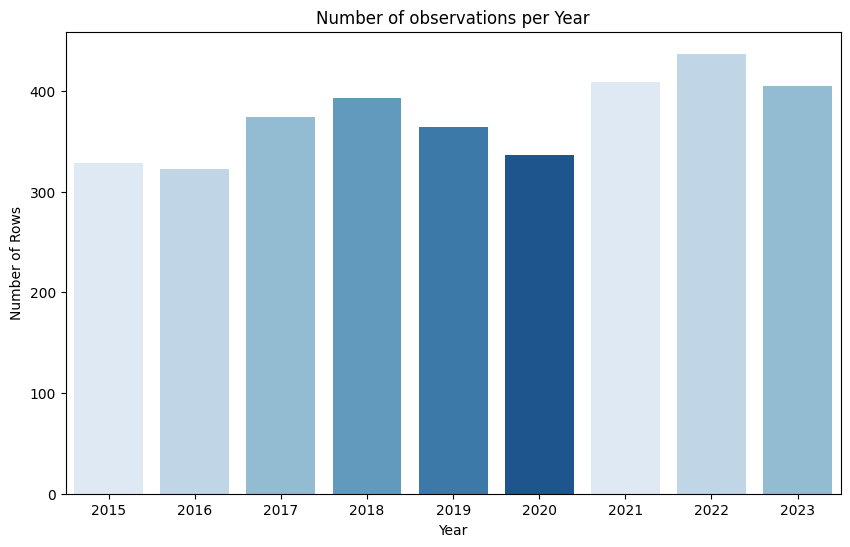

In [ ]:
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette("Blues")

sns.barplot(x=observationsperyear.index, y=observationsperyear.values, palette=custom_palette)


plt.title('Number of observations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Rows')


plt.show()

there is almost same amount of data from each year which is a good thing

##Univariate Analysis


### Points

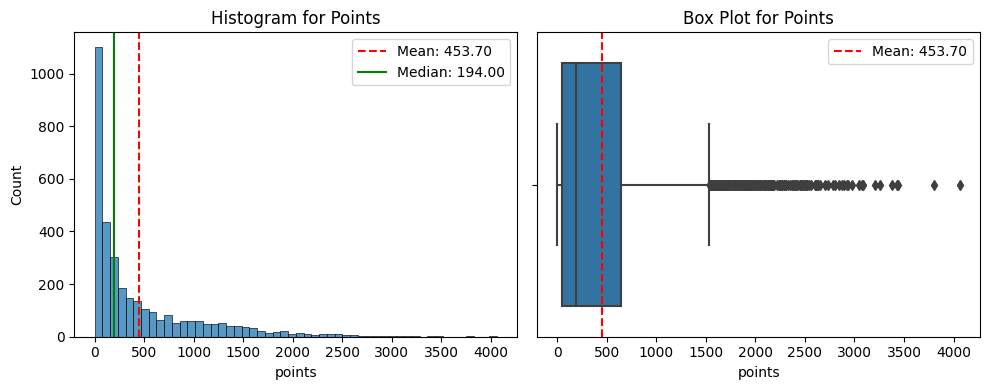

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


points_mean = final_data['points'].mean()
points_median = final_data['points'].median()


sns.histplot(final_data['points'], ax=ax1)
ax1.axvline(points_mean, color='red', linestyle='--', label=f'Mean: {points_mean:.2f}')
ax1.axvline(points_median, color='green', linestyle='-', label=f'Median: {points_median:.2f}')
ax1.set_title('Histogram for Points')
ax1.legend()


sns.boxplot(x=final_data['points'], ax=ax2)
ax2.axvline(points_mean, color='red', linestyle='--', label=f'Mean: {points_mean:.2f}')

ax2.set_title('Box Plot for Points')
ax2.legend()


plt.tight_layout()
plt.show()


### Field Goals Made

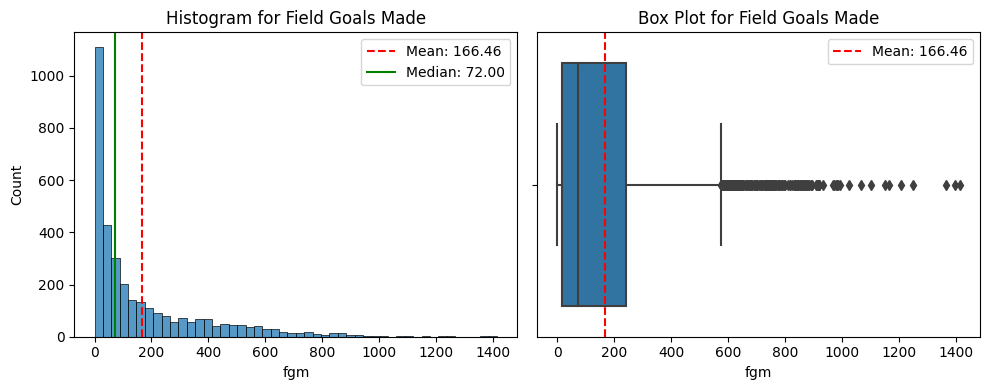

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


fgm_mean = final_data['fgm'].mean()
fgm_median = final_data['fgm'].median()


sns.histplot(final_data['fgm'], ax=ax1)
ax1.axvline(fgm_mean, color='red', linestyle='--', label=f'Mean: {fgm_mean:.2f}')
ax1.axvline(fgm_median, color='green', linestyle='-', label=f'Median: {fgm_median:.2f}')
ax1.set_title('Histogram for Field Goals Made')
ax1.legend()


sns.boxplot(x=final_data['fgm'], ax=ax2)
ax2.axvline(fgm_mean, color='red', linestyle='--', label=f'Mean: {fgm_mean:.2f}')

ax2.set_title('Box Plot for Field Goals Made')
ax2.legend()


plt.tight_layout()
plt.show()

### Field Goals Attempted

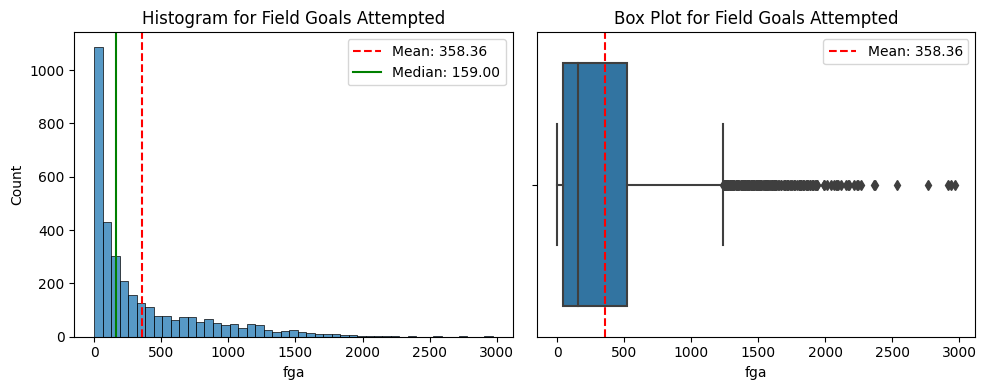

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fga_mean = final_data['fga'].mean()
fga_median = final_data['fga'].median()

sns.histplot(final_data['fga'], ax=ax1)
ax1.axvline(fga_mean, color='red', linestyle='--', label=f'Mean: {fga_mean:.2f}')
ax1.axvline(fga_median, color='green', linestyle='-', label=f'Median: {fga_median:.2f}')
ax1.set_title('Histogram for Field Goals Attempted')
ax1.legend()

sns.boxplot(x=final_data['fga'], ax=ax2)
ax2.axvline(fga_mean, color='red', linestyle='--', label=f'Mean: {fga_mean:.2f}')

ax2.set_title('Box Plot for Field Goals Attempted')
ax2.legend()

plt.tight_layout()
plt.show()

### Free Throws Attempted

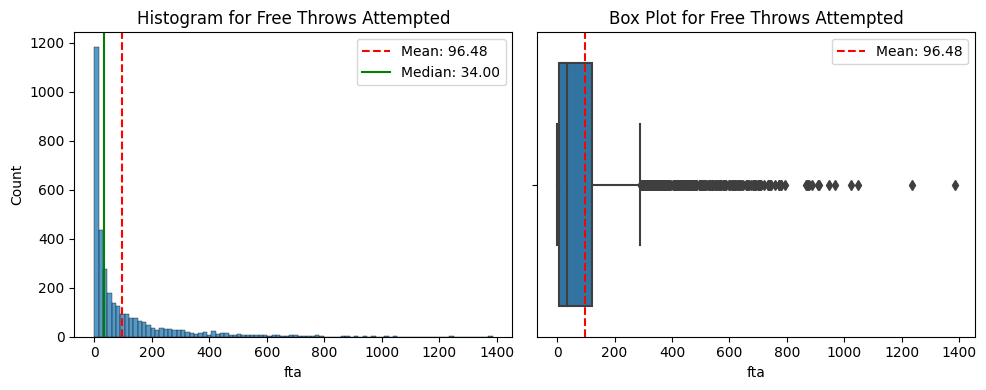

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

fta_mean = final_data['fta'].mean()
fta_median = final_data['fta'].median()

sns.histplot(final_data['fta'], ax=ax1)
ax1.axvline(fta_mean, color='red', linestyle='--', label=f'Mean: {fta_mean:.2f}')
ax1.axvline(fta_median, color='green', linestyle='-', label=f'Median: {fta_median:.2f}')
ax1.set_title('Histogram for Free Throws Attempted')
ax1.legend()

sns.boxplot(x=final_data['fta'], ax=ax2)
ax2.axvline(fta_mean, color='red', linestyle='--', label=f'Mean: {fta_mean:.2f}')

ax2.set_title('Box Plot for Free Throws Attempted')
ax2.legend()

plt.tight_layout()
plt.show()

### Free Throws Made

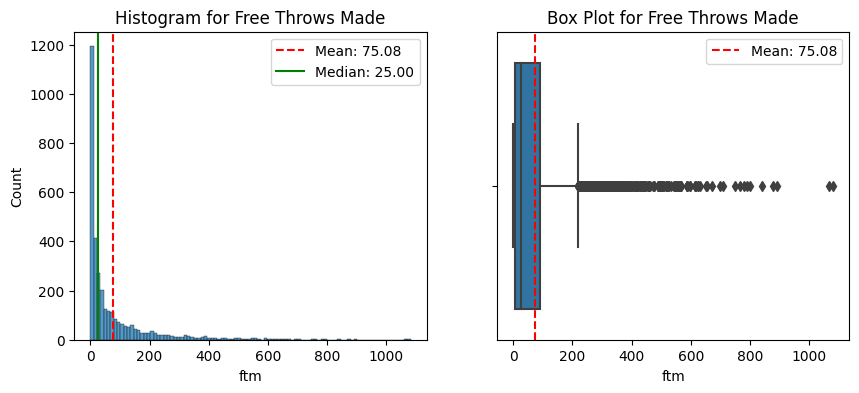

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ftm_mean = final_data['ftm'].mean()
ftm_median = final_data['ftm'].median()

sns.histplot(final_data['ftm'], ax=ax1)
ax1.axvline(ftm_mean, color='red', linestyle='--', label=f'Mean: {ftm_mean:.2f}')
ax1.axvline(ftm_median, color='green', linestyle='-', label=f'Median: {ftm_median:.2f}')
ax1.set_title('Histogram for Free Throws Made')
ax1.legend()

sns.boxplot(x=final_data['ftm'], ax=ax2)
ax2.axvline(ftm_mean, color='red', linestyle='--', label=f'Mean: {ftm_mean:.2f}')
ax2.set_title('Box Plot for Free Throws Made')
ax2.legend()
# Show the plot
plt.show()

### Three Pointers Made

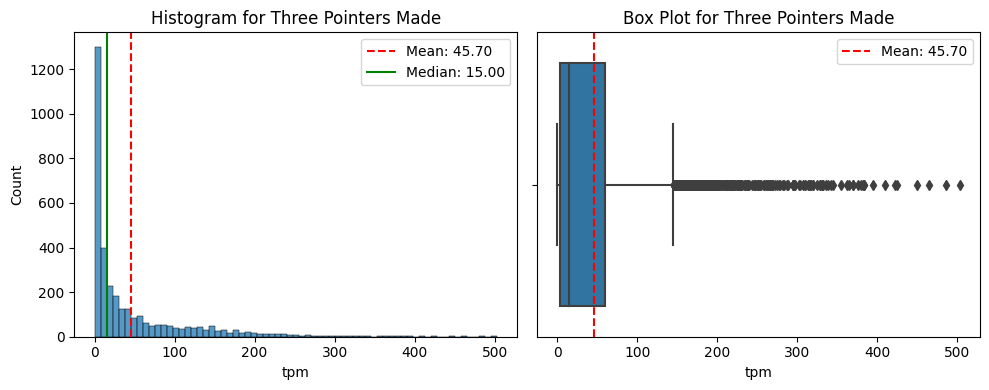

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
tpm_mean = final_data['tpm'].mean()
tpm_median = final_data['tpm'].median()
sns.histplot(final_data['tpm'], ax=ax1)
ax1.axvline(tpm_mean, color='red', linestyle='--', label=f'Mean: {tpm_mean:.2f}')
ax1.axvline(tpm_median, color='green', linestyle='-', label=f'Median: {tpm_median:.2f}')
ax1.set_title('Histogram for Three Pointers Made')
ax1.legend()
sns.boxplot(x=final_data['tpm'], ax=ax2)
ax2.axvline(tpm_mean, color='red', linestyle='--', label=f'Mean: {tpm_mean:.2f}')
ax2.set_title('Box Plot for Three Pointers Made')
ax2.legend()
plt.tight_layout()
plt.show()

### Total Rebounds

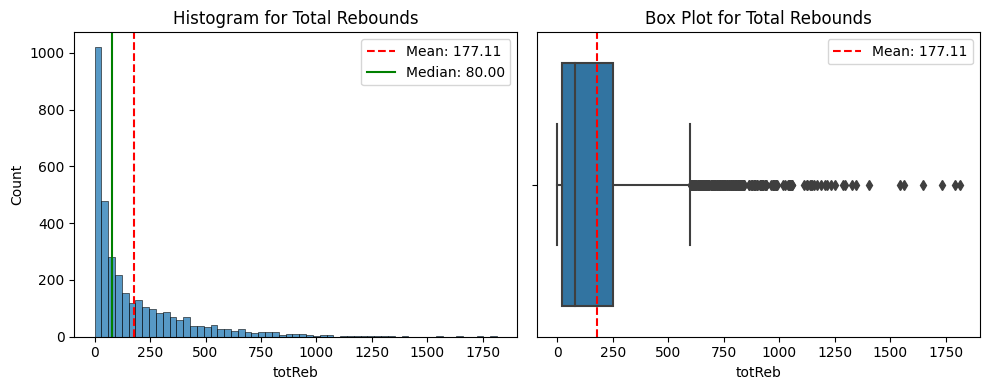

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
totReb_mean = final_data['totReb'].mean()
totReb_median = final_data['totReb'].median()

sns.histplot(final_data['totReb'], ax=ax1)
ax1.axvline(totReb_mean, color='red', linestyle='--', label=f'Mean: {totReb_mean:.2f}')
ax1.axvline(totReb_median, color='green', linestyle='-', label=f'Median: {totReb_median:.2f}')
ax1.set_title('Histogram for Total Rebounds')
ax1.legend()

sns.boxplot(x=final_data['totReb'], ax=ax2)
ax2.axvline(totReb_mean, color='red', linestyle='--', label=f'Mean: {totReb_mean:.2f}')

ax2.set_title('Box Plot for Total Rebounds')
ax2.legend()

plt.tight_layout()
plt.show()

### Blocks

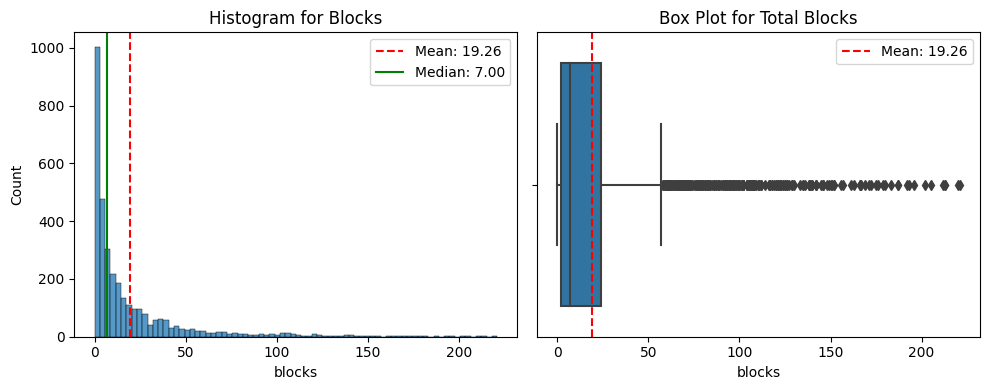

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

blocks_mean = final_data['blocks'].mean()
blocks_median = final_data['blocks'].median()

sns.histplot(final_data['blocks'], ax=ax1)
ax1.axvline(blocks_mean, color='red', linestyle='--', label=f'Mean: {blocks_mean:.2f}')
ax1.axvline(blocks_median, color='green', linestyle='-', label=f'Median: {blocks_median:.2f}')
ax1.set_title('Histogram for Blocks')
ax1.legend()

sns.boxplot(x=final_data['blocks'], ax=ax2)
ax2.axvline(blocks_mean, color='red', linestyle='--', label=f'Mean: {blocks_mean:.2f}')

ax2.set_title('Box Plot for Total Blocks')
ax2.legend()

plt.tight_layout()
plt.show()

### Salary

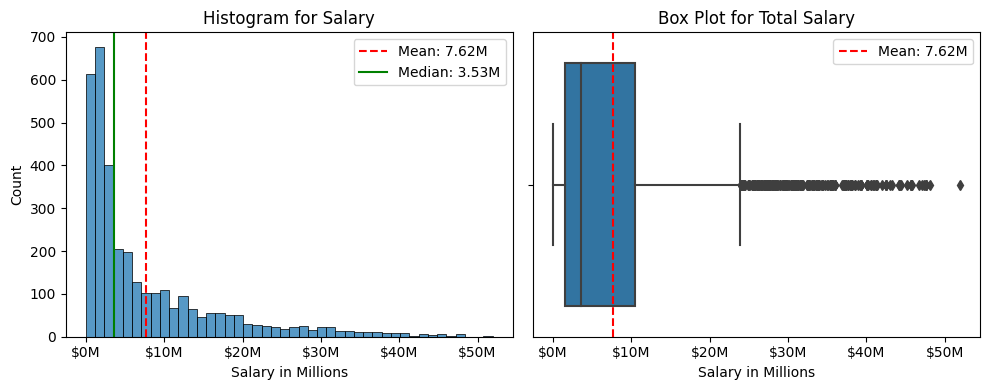

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

salary_mean = final_data['salary'].mean() / 1e6
salary_median = final_data['salary'].median() / 1e6


sns.histplot(final_data['salary'] / 1e6, ax=ax1)
ax1.axvline(salary_mean, color='red', linestyle='--', label=f'Mean: {salary_mean:.2f}M')
ax1.axvline(salary_median, color='green', linestyle='-', label=f'Median: {salary_median:.2f}M')
ax1.set_title('Histogram for Salary')
ax1.set_xlabel('Salary in Millions')
ax1.legend()


sns.boxplot(x=final_data['salary'] / 1e6, ax=ax2)
ax2.axvline(salary_mean, color='red', linestyle='--', label=f'Mean: {salary_mean:.2f}M')
ax2.set_title('Box Plot for Total Salary')
ax2.set_xlabel('Salary in Millions')
ax2.legend()


ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}M'))
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}M'))


plt.tight_layout()
plt.show()

###Log(Salary)

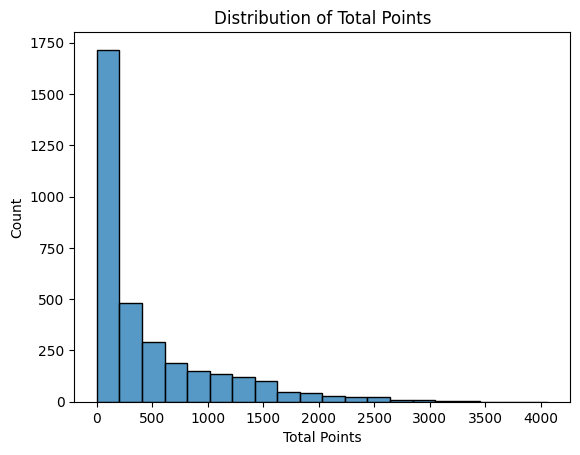

In [ ]:

df = final_data.drop(columns=['player','year'])
df['log_salary'] = np.log(df['salary'])


df['per'] = df['points'] / df['fga']
df['ts_pct'] = df['points'] / (2 * (df['fga'] + 0.44 * df['fta']))


sns.histplot(df['points'], bins=20)
plt.xlabel('Total Points')
plt.title('Distribution of Total Points')
plt.show()


##Bivariate Analysis


### Field Goals Attempted VS Field Goals Made

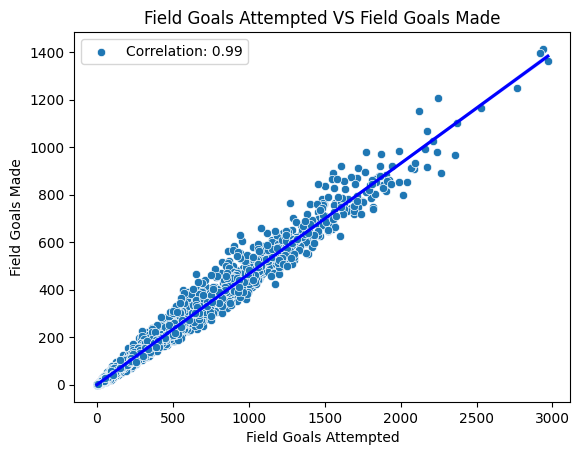

In [ ]:
corrfgafgm = final_data['fga'].corr(final_data['fgm'])
sns.scatterplot(x='fga', y='fgm', data=final_data)
sns.regplot(x='fga', y='fgm', data=final_data, scatter=False, color='blue')
plt.title('Field Goals Attempted VS Field Goals Made')
plt.xlabel('Field Goals Attempted')
plt.ylabel('Field Goals Made')
plt.legend([f'Correlation: {corrfgafgm:.2f}'])
plt.show()

### Field Goals Attempted VS Points

---



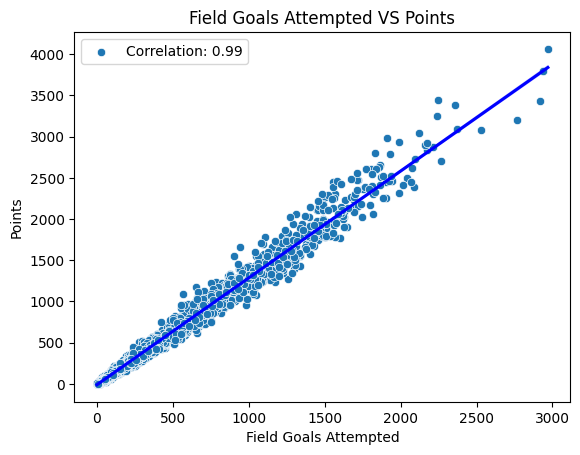

In [ ]:
corrfgapoints = final_data['fga'].corr(final_data['points'])
sns.scatterplot(x='fga', y='points', data=final_data)
sns.regplot(x='fga', y='points', data=final_data, scatter=False, color='blue')
plt.title('Field Goals Attempted VS Points')
plt.xlabel('Field Goals Attempted')
plt.ylabel('Points')
plt.legend([f'Correlation: {corrfgapoints:.2f}'])
plt.show()

### Field Goals Attempted VS Salary

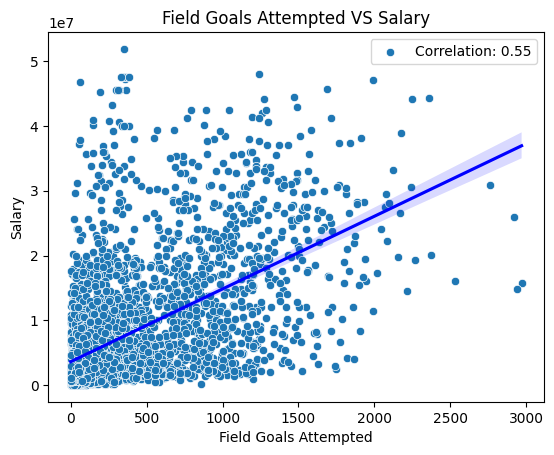

In [ ]:
corrfgasal = final_data['fga'].corr(final_data['salary'])
sns.scatterplot(x='fga', y='salary', data=final_data)
sns.regplot(x='fga', y='salary', data=final_data, scatter=False, color='blue')
plt.title('Field Goals Attempted VS Salary')
plt.xlabel('Field Goals Attempted')
plt.ylabel('Salary')
plt.legend([f'Correlation: {corrfgasal:.2f}'])
plt.show()

### Field Goals Made VS Salary

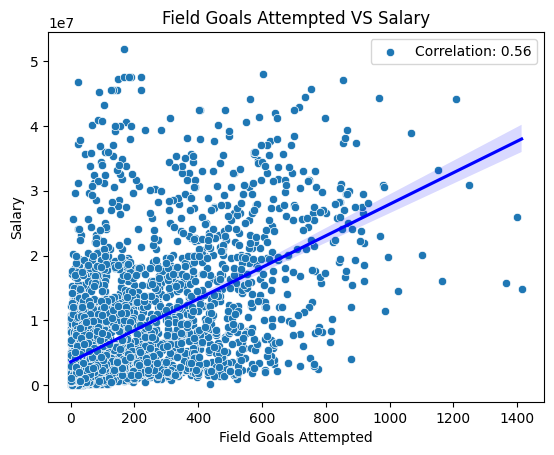

In [ ]:
corrfgasal = final_data['fgm'].corr(final_data['salary'])
sns.scatterplot(x='fgm', y='salary', data=final_data)
sns.regplot(x='fgm', y='salary', data=final_data, scatter=False, color='blue')
plt.title('Field Goals Attempted VS Salary')
plt.xlabel('Field Goals Attempted')
plt.ylabel('Salary')
plt.legend([f'Correlation: {corrfgasal:.2f}'])
plt.show()

###Points VS Salary

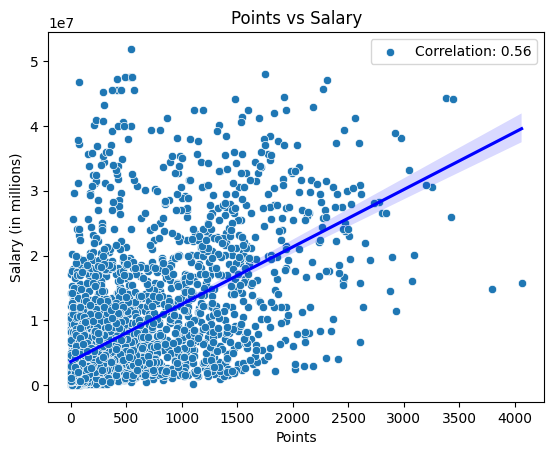

In [ ]:
corrpoisal = final_data['points'].corr(final_data['salary'])
sns.scatterplot(x='points', y='salary', data=final_data)
sns.regplot(x='points', y='salary', data=final_data, scatter=False, color='blue')
plt.title('Points vs Salary')
plt.xlabel('Points')
plt.ylabel('Salary (in millions)')
plt.legend([f'Correlation: {corrpoisal:.2f}'])
plt.show()


### Plus Minus VS Salary

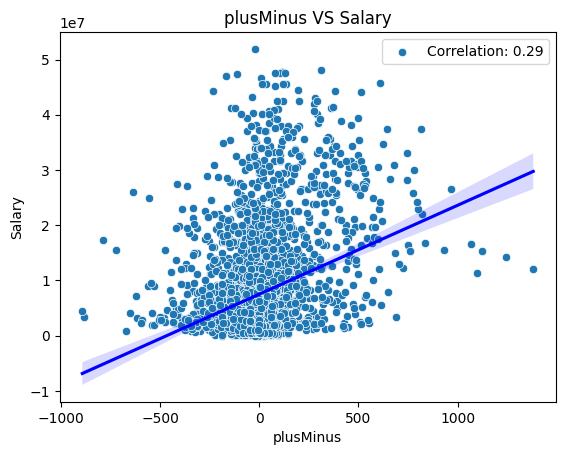

In [ ]:
corrpmsal = final_data['plusMinus'].corr(final_data['salary'])
sns.scatterplot(x='plusMinus', y='salary', data=final_data)
sns.regplot(x='plusMinus', y='salary', data=final_data, scatter=False, color='blue')
plt.title('plusMinus VS Salary')
plt.xlabel('plusMinus')
plt.ylabel('Salary')
plt.legend([f'Correlation: {corrpmsal:.2f}'])
plt.show()

### Year VS Salary

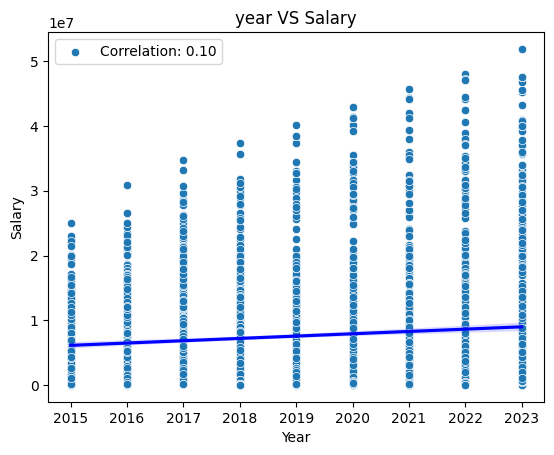

In [ ]:
corryrsal = final_data['year'].corr(final_data['salary'])
sns.scatterplot(x='year', y='salary', data=final_data)
sns.regplot(x='year', y='salary', data=final_data, scatter=False, color='blue')
plt.title('year VS Salary')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend([f'Correlation: {corryrsal:.2f}'])
plt.show()

### Fouls VS Salary

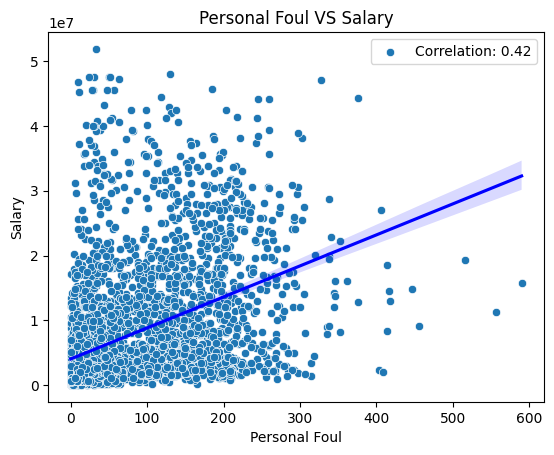

In [ ]:
corrfoulsal = final_data['pFouls'].corr(final_data['salary'])
sns.scatterplot(x='pFouls', y='salary', data=final_data)
sns.regplot(x='pFouls', y='salary', data=final_data, scatter=False, color='blue')
plt.title('Personal Foul VS Salary')
plt.xlabel('Personal Foul')
plt.ylabel('Salary')
plt.legend([f'Correlation: {corrfoulsal:.2f}'])
plt.show()

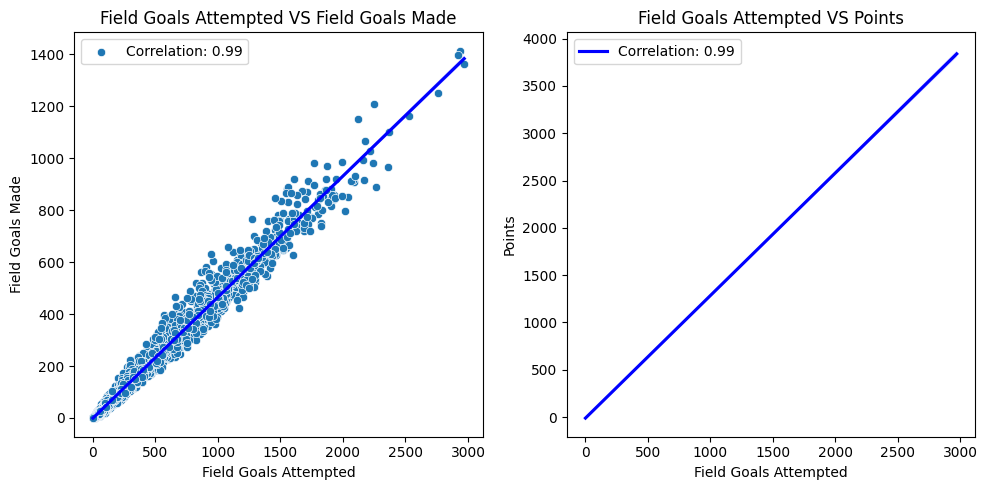

In [ ]:

corrfgafgm = final_data['fga'].corr(final_data['fgm'])
corrfgapoints = final_data['fga'].corr(final_data['points'])


fig, axes = plt.subplots(1, 2, figsize=(10, 5))


sns.scatterplot(x='fga', y='fgm', data=final_data, ax=axes[0])
sns.regplot(x='fga', y='fgm', data=final_data, scatter=False, color='blue', ax=axes[0])
axes[0].set_title('Field Goals Attempted VS Field Goals Made')
axes[0].set_xlabel('Field Goals Attempted')
axes[0].set_ylabel('Field Goals Made')
axes[0].legend([f'Correlation: {corrfgafgm:.2f}'])


sns.regplot(x='fga', y='points', data=final_data, scatter=False, color='blue', ax=axes[1])
axes[1].set_title('Field Goals Attempted VS Points')
axes[1].set_xlabel('Field Goals Attempted')
axes[1].set_ylabel('Points')
axes[1].legend([f'Correlation: {corrfgapoints:.2f}'])

plt.tight_layout()
plt.show()

## Multivariate Analysis

### Corelation

In [ ]:
corr = final_data.corr()
corr

<ipython-input-45-abfc836b8339>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = final_data.corr()


fga    defReb       fgm       tpm    totReb    offReb  \
fga        1.000000  0.836960  0.991118  0.836137  0.798154  0.586744   
defReb     0.836960  1.000000  0.868603  0.574025  0.990281  0.842837   
fgm        0.991118  0.868603  1.000000  0.787564  0.838142  0.646892   
tpm        0.836137  0.574025  0.787564  1.000000  0.505345  0.239650   
totReb     0.798154  0.990281  0.838142  0.505345  1.000000  0.909496   
offReb     0.586744  0.842837  0.646892  0.239650  0.909496  1.000000   
turnovers  0.926846  0.837711  0.926256  0.713789  0.803523  0.605270   
fta        0.893784  0.823611  0.907003  0.633601  0.798577  0.628277   
pFouls     0.857948  0.882365  0.864691  0.680001  0.875979  0.752165   
assists    0.841125  0.698086  0.829851  0.694161  0.650834  0.431789   
points     0.992751  0.850805  0.994579  0.819551  0.813985  0.606616   
steals     0.862499  0.781522  0.852105  0.730529  0.755164  0.586100   
plusMinus  0.289135  0.279825  0.316565  0.288697  0.259931  0.169394   
ftm        0.898409  0.783381  0.903682  0.673096  0.749245  0.557638   
tpa        0.855274  0.597717  0.803295  0.993400  0.528947  0.260160   
blocks     0.598173  0.789408  0.643471  0.330126  0.811583  0.780833   
year      -0.110610 -0.113150 -0.102426 -0.029211 -0.111406 -0.092874   
salary     0.548551  0.495926  0.559180  0.433707  0.470340  0.337631   

           turnovers       fta    pFouls   assists    points    steals  \
fga         0.926846  0.893784  0.857948  0.841125  0.992751  0.862499   
defReb      0.837711  0.823611  0.882365  0.698086  0.850805  0.781522   
fgm         0.926256  0.907003  0.864691  0.829851  0.994579  0.852105   
tpm         0.713789  0.633601  0.680001  0.694161  0.819551  0.730529   
totReb      0.803523  0.798577  0.875979  0.650834  0.813985  0.755164   
offReb      0.605270  0.628277  0.752165  0.431789  0.606616  0.586100   
turnovers   1.000000  0.909995  0.839979  0.918128  0.932427  0.852781   
fta         0.909995  1.000000  0.770063  0.799371  0.927044  0.769946   
pFouls      0.839979  0.770063  1.000000  0.716856  0.852224  0.852558   
assists     0.918128  0.799371  0.716856  1.000000  0.842021  0.821784   
points      0.932427  0.927044  0.852224  0.842021  1.000000  0.852727   
steals      0.852781  0.769946  0.852558  0.821784  0.852727  1.000000   
plusMinus   0.273507  0.315791  0.215733  0.316135  0.327638  0.296897   
ftm         0.901336  0.989228  0.743547  0.808993  0.931416  0.761847   
tpa         0.742993  0.662799  0.702702  0.719947  0.835450  0.752740   
blocks      0.589821  0.619226  0.740046  0.418054  0.617286  0.590006   
year       -0.115434 -0.107073 -0.120197 -0.070110 -0.097426 -0.132010   
salary      0.531049  0.547686  0.418433  0.518066  0.564699  0.449408   

           plusMinus       ftm       tpa    blocks      year    salary  
fga         0.289135  0.898409  0.855274  0.598173 -0.110610  0.548551  
defReb      0.279825  0.783381  0.597717  0.789408 -0.113150  0.495926  
fgm         0.316565  0.903682  0.803295  0.643471 -0.102426  0.559180  
tpm         0.288697  0.673096  0.993400  0.330126 -0.029211  0.433707  
totReb      0.259931  0.749245  0.528947  0.811583 -0.111406  0.470340  
offReb      0.169394  0.557638  0.260160  0.780833 -0.092874  0.337631  
turnovers   0.273507  0.901336  0.742993  0.589821 -0.115434  0.531049  
fta         0.315791  0.989228  0.662799  0.619226 -0.107073  0.547686  
pFouls      0.215733  0.743547  0.702702  0.740046 -0.120197  0.418433  
assists     0.316135  0.808993  0.719947  0.418054 -0.070110  0.518066  
points      0.327638  0.931416  0.835450  0.617286 -0.097426  0.564699  
steals      0.296897  0.761847  0.752740  0.590006 -0.132010  0.449408  
plusMinus   1.000000  0.326678  0.268633  0.254446 -0.019361  0.294210  
ftm         0.326678  1.000000  0.699451  0.570650 -0.100104  0.551396  
tpa         0.268633  0.699451  1.000000  0.350364 -0.028342  0.443841  
blocks      0.254446  0.570650  0.350364  1.000000 -0

### Corelation HeatMap

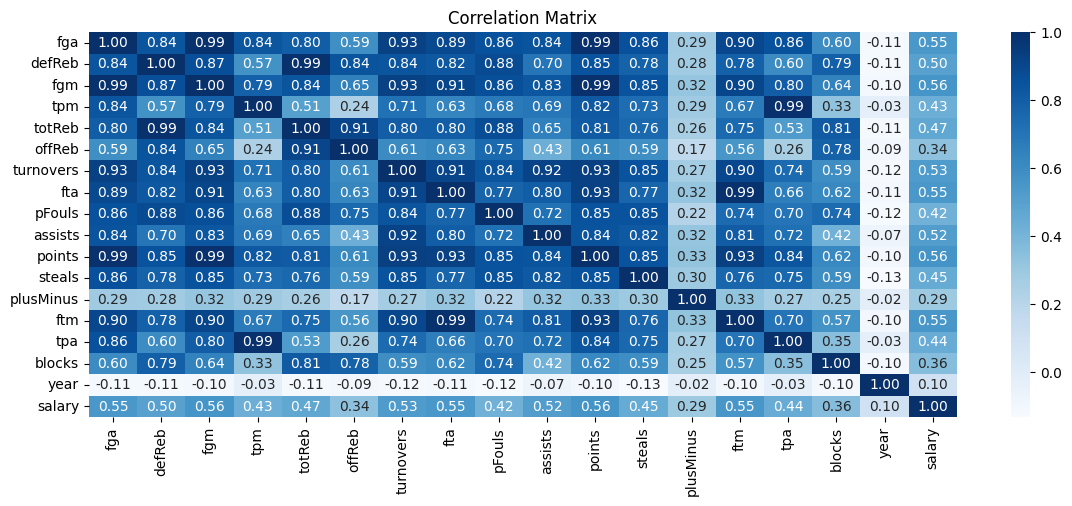

In [ ]:

plt.figure(figsize=(14, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

### Pair Plot

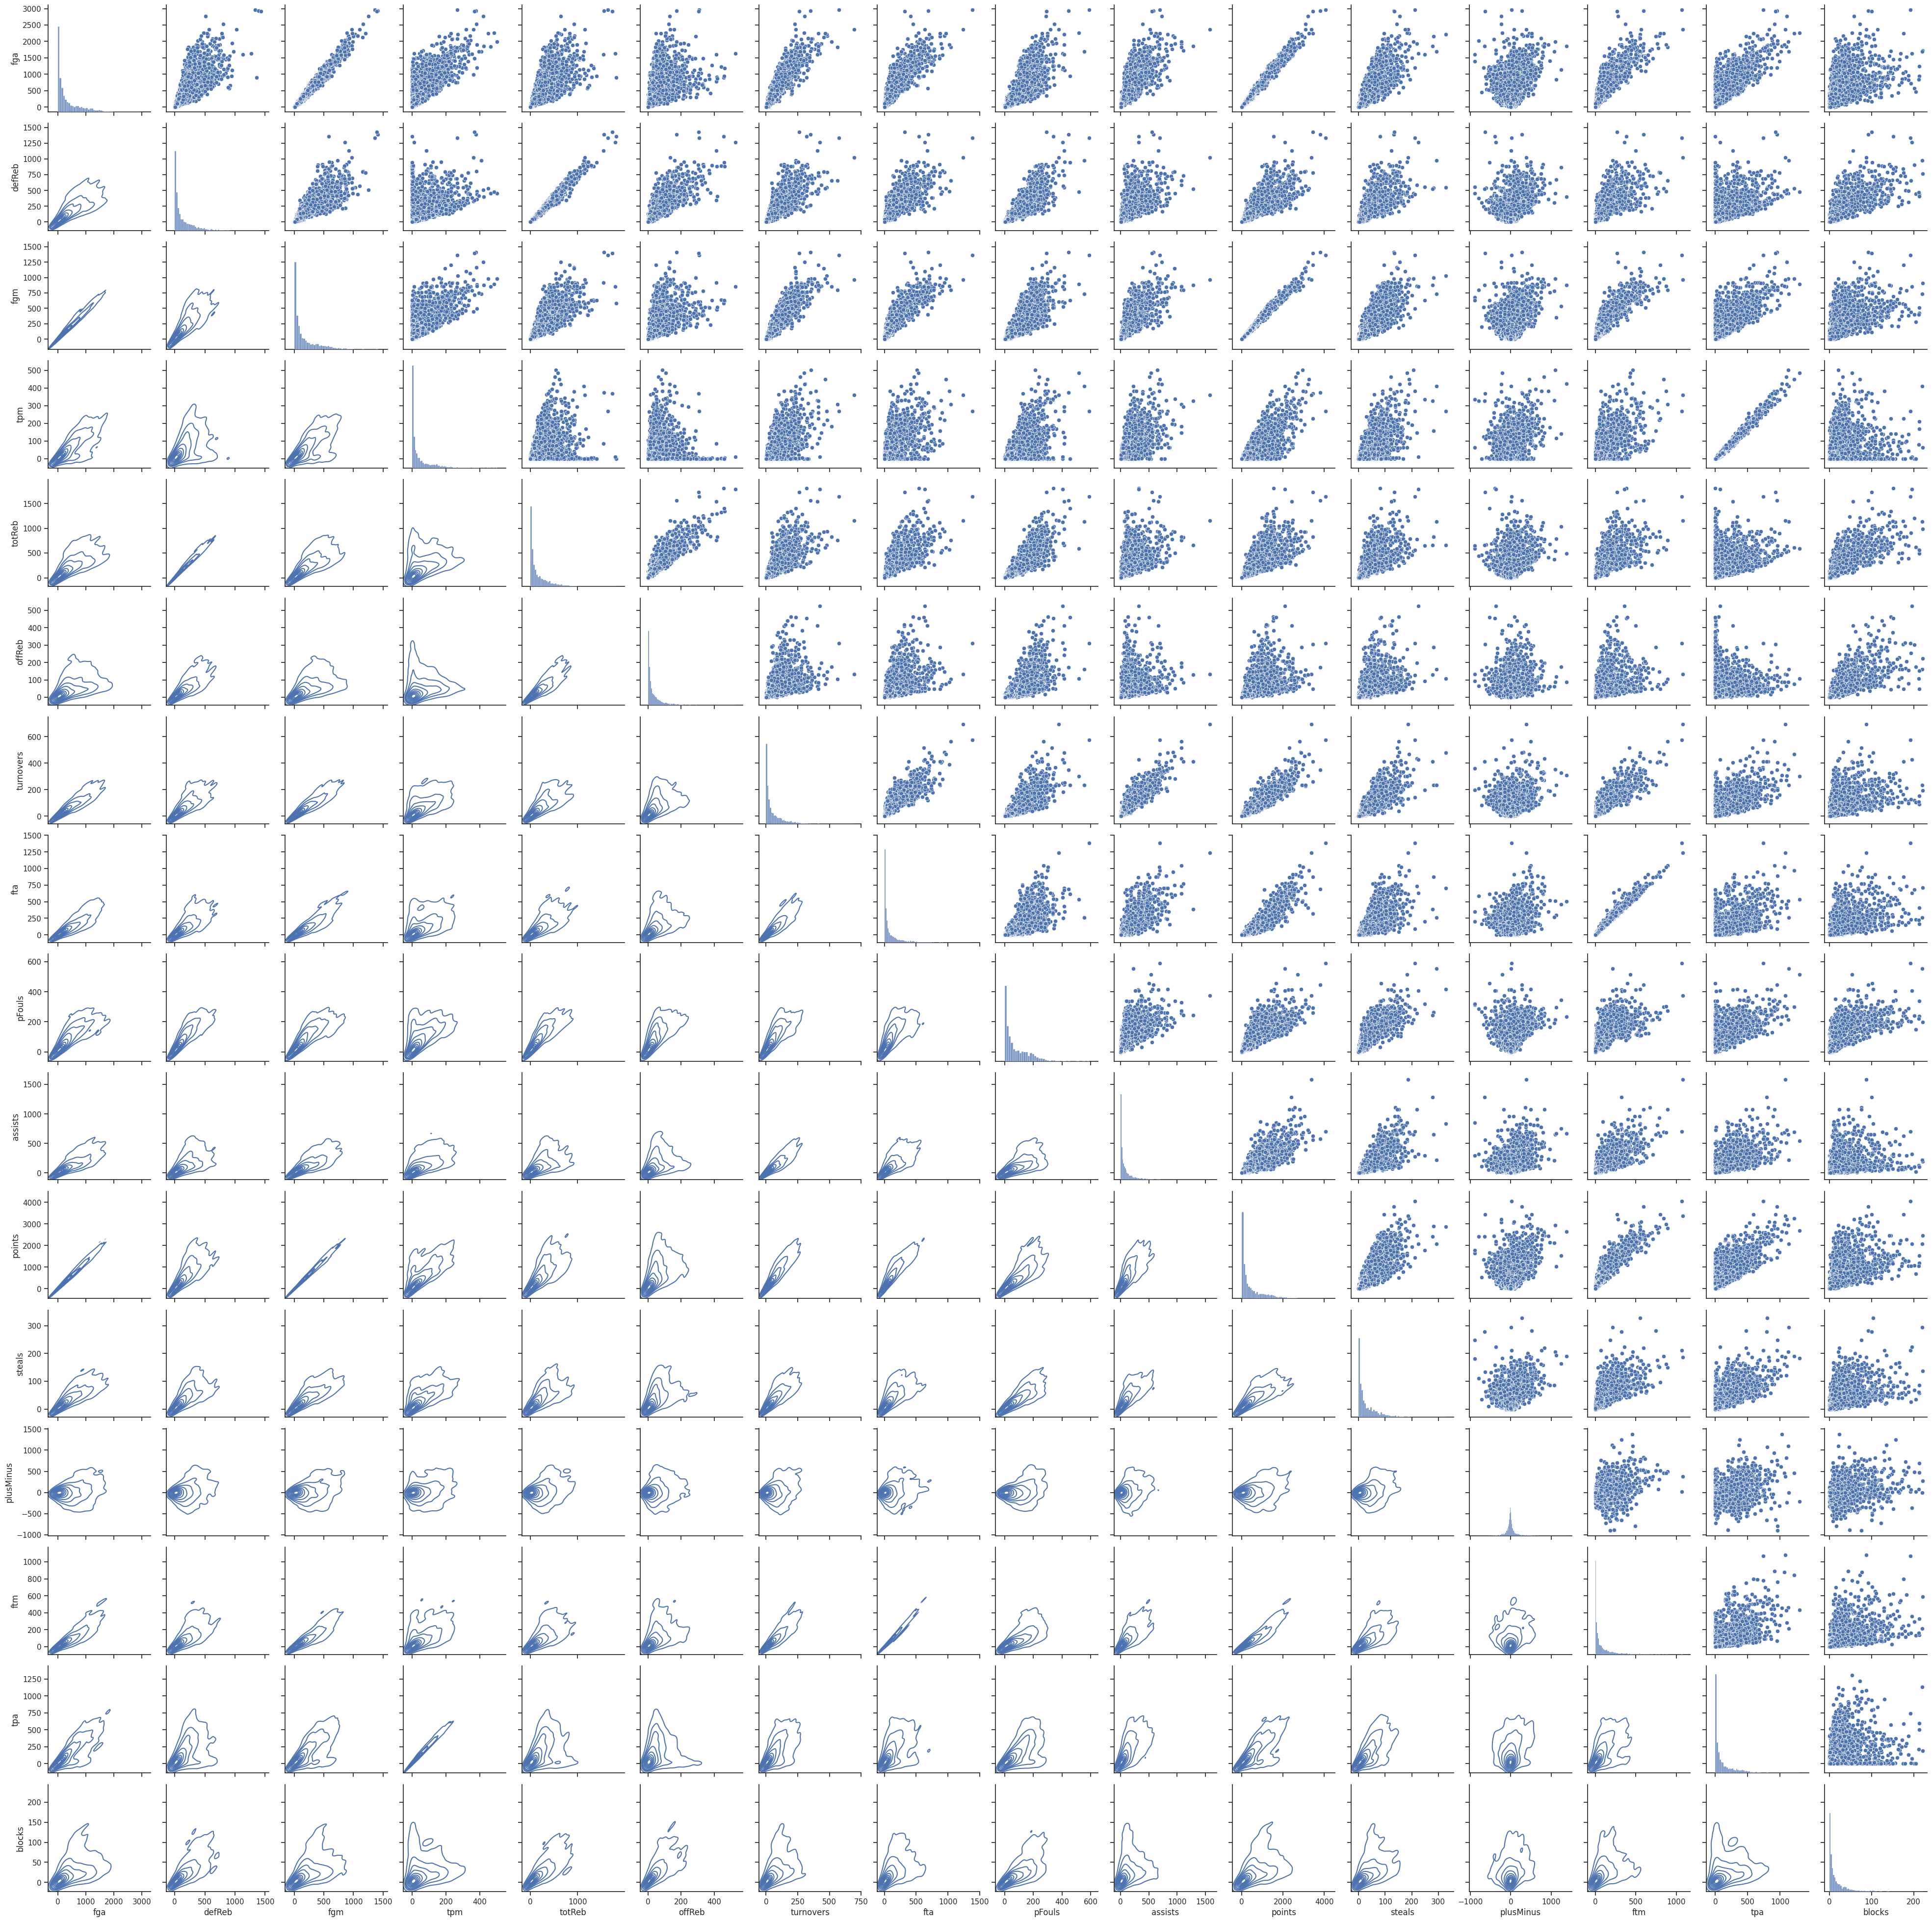

In [ ]:
numerical_columns = ['fga', 'defReb', 'fgm', 'tpm', 'totReb', 'offReb', 'turnovers', 'fta', 'pFouls', 'assists', 'points', 'steals', 'plusMinus', 'ftm', 'tpa', 'blocks']


sns.set(style="ticks")
g = sns.PairGrid(final_data, vars=numerical_columns)
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot)
g.map_lower(sns.kdeplot)
plt.show()

## Feature Engineering

In [ ]:
final_data.columns

Index(['player', 'fga', 'defReb', 'fgm', 'tpm', 'totReb', 'offReb',
       'turnovers', 'fta', 'pFouls', 'assists', 'points', 'steals',
       'plusMinus', 'ftm', 'tpa', 'blocks', 'year', 'salary'],
      dtype='object')

### Field Goal Accuracy

measured the field accuracy by dividing fgm by fga

In [ ]:
final_data['fg_accuracy'] = (final_data['fgm'] / final_data['fga']) * 100
final_data.head()

player    fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0     Quincy Acy  118.0    72.0   73.0  11.0    99.0    27.0       14.0   
1   Steven Adams  564.0   443.0  348.0   0.0   741.0   298.0      114.0   
2  Arron Afflalo  686.0   208.0  314.0  81.0   226.0    18.0       67.0   
3  Alexis Ajinca  151.0    78.0   72.0   0.0   108.0    30.0       30.0   
4   Cole Aldrich   52.0    39.0   33.0   0.0    55.0    16.0       10.0   

     fta  pFouls  assists  points  steals  plusMinus    ftm    tpa  blocks  \
0   34.0    65.0     17.0   184.0    15.0      -85.0   27.0   25.0    14.0   
1  290.0   292.0     82.0   869.0    53.0      551.0  173.0    1.0   108.0   
2  110.0   126.0    114.0   806.0    23.0      -61.0   97.0  206.0     9.0   
3   25.0    51.0     17.0   166.0     4.0      -82.0   22.0    0.0    13.0   
4   19.0    13.0     10.0    79.0    12.0       29.0   13.0    0.0     7.0   

   year     salary  fg_accuracy  
0  2015   981348.0    61.864407  
1  2015  2279040.0    61.702128  
2  2015  8000000.0    45.772595  
3  2015  4539607.0    47.682119  
4  2015  1100602.0    63.461538

### Three Pointer Accuracy

measured the three point accuracy by dividing the tpm bt tpa

In [ ]:
final_data['tp_accuracy'] = (final_data['tpm'] / final_data['tpa']) * 100
final_data.head()

player    fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0     Quincy Acy  118.0    72.0   73.0  11.0    99.0    27.0       14.0   
1   Steven Adams  564.0   443.0  348.0   0.0   741.0   298.0      114.0   
2  Arron Afflalo  686.0   208.0  314.0  81.0   226.0    18.0       67.0   
3  Alexis Ajinca  151.0    78.0   72.0   0.0   108.0    30.0       30.0   
4   Cole Aldrich   52.0    39.0   33.0   0.0    55.0    16.0       10.0   

     fta  pFouls  ...  points  steals  plusMinus    ftm    tpa  blocks  year  \
0   34.0    65.0  ...   184.0    15.0      -85.0   27.0   25.0    14.0  2015   
1  290.0   292.0  ...   869.0    53.0      551.0  173.0    1.0   108.0  2015   
2  110.0   126.0  ...   806.0    23.0      -61.0   97.0  206.0     9.0  2015   
3   25.0    51.0  ...   166.0     4.0      -82.0   22.0    0.0    13.0  2015   
4   19.0    13.0  ...    79.0    12.0       29.0   13.0    0.0     7.0  2015   

      salary  fg_accuracy  tp_accuracy  
0   981348.0    61.864407    44.000000  
1  2279040.0    61.702128     0.000000  
2  8000000.0    45.772595    39.320388  
3  4539607.0    47.682119          NaN  
4  1100602.0    63.461538          NaN  

[5 rows x 21 columns]

### Free Throw Accuracy

measured the free throw accuracy by dividing the ftm bt fta

In [ ]:
final_data['ft_accuracy'] = (final_data['ftm'] / final_data['fta']) * 100
final_data.head()

player    fga  defReb    fgm   tpm  totReb  offReb  turnovers  \
0     Quincy Acy  118.0    72.0   73.0  11.0    99.0    27.0       14.0   
1   Steven Adams  564.0   443.0  348.0   0.0   741.0   298.0      114.0   
2  Arron Afflalo  686.0   208.0  314.0  81.0   226.0    18.0       67.0   
3  Alexis Ajinca  151.0    78.0   72.0   0.0   108.0    30.0       30.0   
4   Cole Aldrich   52.0    39.0   33.0   0.0    55.0    16.0       10.0   

     fta  pFouls  ...  steals  plusMinus    ftm    tpa  blocks  year  \
0   34.0    65.0  ...    15.0      -85.0   27.0   25.0    14.0  2015   
1  290.0   292.0  ...    53.0      551.0  173.0    1.0   108.0  2015   
2  110.0   126.0  ...    23.0      -61.0   97.0  206.0     9.0  2015   
3   25.0    51.0  ...     4.0      -82.0   22.0    0.0    13.0  2015   
4   19.0    13.0  ...    12.0       29.0   13.0    0.0     7.0  2015   

      salary  fg_accuracy  tp_accuracy  ft_accuracy  
0   981348.0    61.864407    44.000000    79.411765  
1  2279040.0    61.702128     0.000000    59.655172  
2  8000000.0    45.772595    39.320388    88.181818  
3  4539607.0    47.682119          NaN    88.000000  
4  1100602.0    63.461538          NaN    68.421053  

[5 rows x 22 columns]

In [ ]:
new_column_order = ['player', 'year','fga', 'fgm','fg_accuracy',
                    'tpa','tpm','tp_accuracy',
                    'fta','ftm','ft_accuracy',
                    'offReb','defReb','totReb','turnovers','pFouls','assists',
                    'steals','plusMinus','blocks','points','salary']

final_data = final_data[new_column_order]

final_data.head()


player  year    fga    fgm  fg_accuracy    tpa   tpm  tp_accuracy  \
0     Quincy Acy  2015  118.0   73.0    61.864407   25.0  11.0    44.000000   
1   Steven Adams  2015  564.0  348.0    61.702128    1.0   0.0     0.000000   
2  Arron Afflalo  2015  686.0  314.0    45.772595  206.0  81.0    39.320388   
3  Alexis Ajinca  2015  151.0   72.0    47.682119    0.0   0.0          NaN   
4   Cole Aldrich  2015   52.0   33.0    63.461538    0.0   0.0          NaN   

     fta    ftm  ...  defReb  totReb  turnovers  pFouls  assists  steals  \
0   34.0   27.0  ...    72.0    99.0       14.0    65.0     17.0    15.0   
1  290.0  173.0  ...   443.0   741.0      114.0   292.0     82.0    53.0   
2  110.0   97.0  ...   208.0   226.0       67.0   126.0    114.0    23.0   
3   25.0   22.0  ...    78.0   108.0       30.0    51.0     17.0     4.0   
4   19.0   13.0  ...    39.0    55.0       10.0    13.0     10.0    12.0   

   plusMinus  blocks  points     salary  
0      -85.0    14.0   184.0   981348.0  
1      551.0   108.0   869.0  2279040.0  
2      -61.0     9.0   806.0  8000000.0  
3      -82.0    13.0   166.0  4539607.0  
4       29.0     7.0    79.0  1100602.0  

[5 rows x 22 columns]

In [ ]:
finaldata = final_data.dropna()
finaldata.head()

player  year     fga    fgm  fg_accuracy    tpa   tpm  \
0         Quincy Acy  2015   118.0   73.0    61.864407   25.0  11.0   
1       Steven Adams  2015   564.0  348.0    61.702128    1.0   0.0   
2      Arron Afflalo  2015   686.0  314.0    45.772595  206.0  81.0   
5  LaMarcus Aldridge  2015  1267.0  648.0    51.144436   19.0   2.0   
7         Tony Allen  2015   456.0  210.0    46.052632   45.0  14.0   

   tp_accuracy    fta    ftm  ...  defReb  totReb  turnovers  pFouls  assists  \
0    44.000000   34.0   27.0  ...    72.0    99.0       14.0    65.0     17.0   
1     0.000000  290.0  173.0  ...   443.0   741.0      114.0   292.0     82.0   
2    39.320388  110.0   97.0  ...   208.0   226.0       67.0   126.0    114.0   
5    10.526316  366.0  314.0  ...   537.0   742.0      116.0   180.0    123.0   
7    31.111111  134.0   91.0  ...   181.0   273.0       71.0   164.0     67.0   

   steals  plusMinus  blocks  points      salary  
0    15.0      -85.0    14.0   184.0    981348.0  
1    53.0      551.0   108.0   869.0   2279040.0  
2    23.0      -61.0     9.0   806.0   8000000.0  
5    45.0      568.0    97.0  1612.0  19689000.0  
7   105.0     -108.0    16.0   525.0   5000000.0  

[5 rows x 22 columns]

dropped the null values that arised when calcualting  new features

## Data Analyitcs

### Highest Paid Players

In [ ]:
total_salary_by_player = finaldata.groupby('player')['salary'].sum().sort_values(ascending=False)

top_10_paid_players = total_salary_by_player.head(10)

top_10_paid_players_df = top_10_paid_players.reset_index()

top_10_paid_players_df.columns = ['Player', 'Total Salary']
top_10_paid_players_df['Total Salary in Millions'] = top_10_paid_players_df['Total Salary'] / 1e6




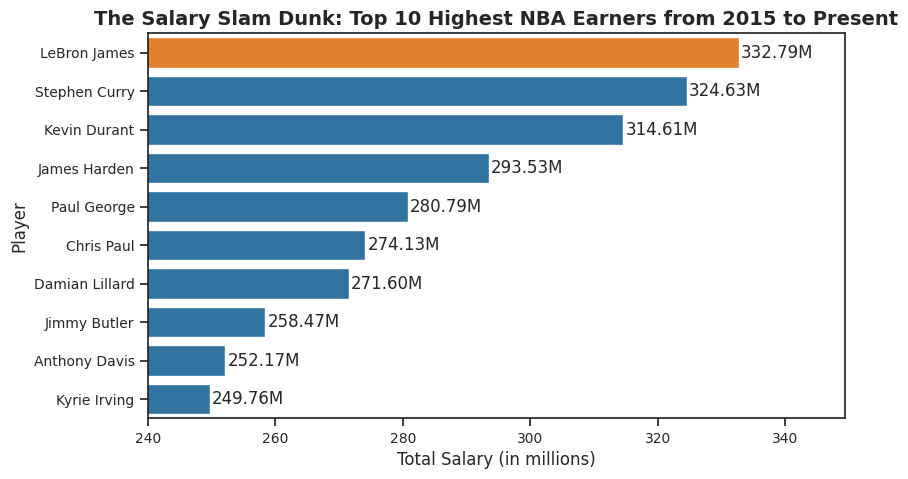

In [ ]:

temp_finaldata = finaldata.copy()
if ('Kevin Durant' not in temp_finaldata[temp_finaldata['year'] == 2019]['player'].values):
    kevin_durant_2019 = pd.DataFrame([{'player': 'Kevin Durant', 'salary': 37199000, 'year': 2019}])
    temp_finaldata = pd.concat([temp_finaldata, kevin_durant_2019], ignore_index=True)

temp_total_salary_by_player = temp_finaldata.groupby('player')['salary'].sum().sort_values(ascending=False)
temp_top_10_paid_players = temp_total_salary_by_player.head(10)
temp_top_10_paid_players_df = temp_top_10_paid_players.reset_index()
temp_top_10_paid_players_df.columns = ['Player', 'Total Salary']
temp_top_10_paid_players_df['Total Salary in Millions'] = temp_top_10_paid_players_df['Total Salary'] / 1e6


bar_colors = ['#1f77b4' if i > 0 else '#ff7f0e' for i in range(len(top_10_paid_players_df))]


plt.figure(figsize=(9, 5))
barplot = sns.barplot(
    x='Total Salary in Millions',
    y='Player',
    data=temp_top_10_paid_players_df,
    orient='h',
    palette=bar_colors
)

for p in barplot.patches:
    width = p.get_width()
    plt.text(
        width + 6,
        p.get_y() + p.get_height() / 2,
        f'{width:,.2f}M',
        ha = 'center',
        va = 'center'
    )


plt.title('The Salary Slam Dunk: Top 10 Highest NBA Earners from 2015 to Present', fontsize=14, weight='bold')
plt.xlabel('Total Salary (in millions)', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(left=240)


plt.show()


### The Golden Era: Stephen Curry's Reign as the NBA's Top Earner

In [ ]:
highest_paid_each_year = finaldata.sort_values(by=['year', 'salary'], ascending=[True, False])
highest_paid_each_year = highest_paid_each_year.groupby('year').first().reset_index()


highest_paid_each_year = highest_paid_each_year[['player', 'year', 'salary']]


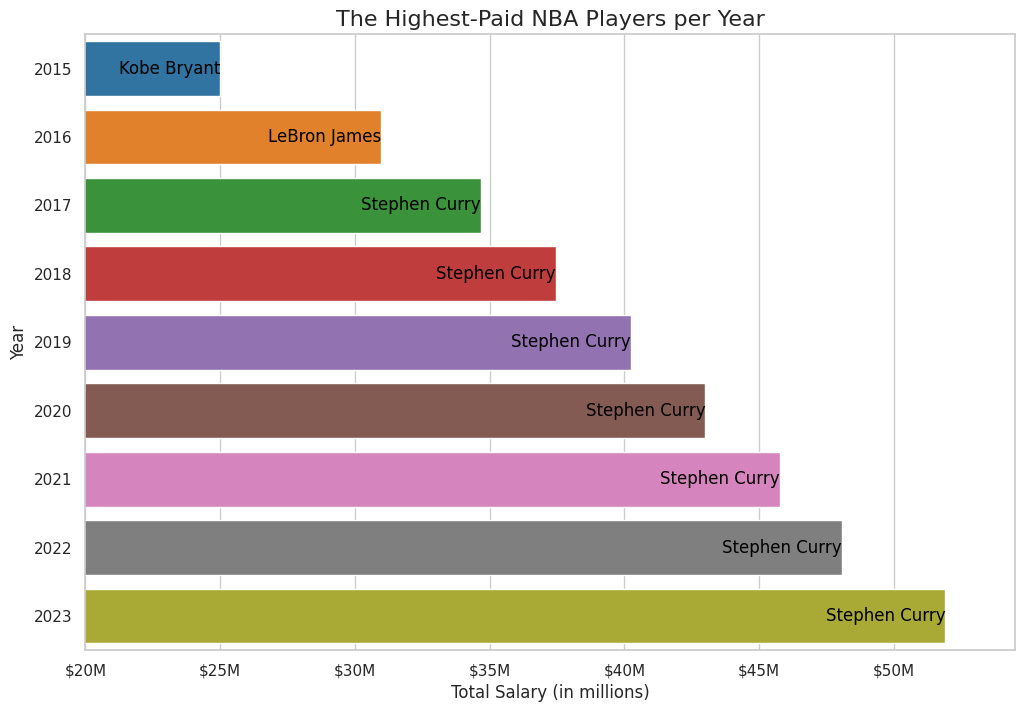

In [ ]:
highest_paid_each_year['salary_in_millions'] = highest_paid_each_year['salary'] / 1e6

highest_paid_each_year.sort_values('year', inplace=True)


sns.set_style("whitegrid")


plt.figure(figsize=(12, 8))


sns.barplot(x='salary_in_millions', y='year', data=highest_paid_each_year, orient='h', palette='tab10')


for index, row in highest_paid_each_year.iterrows():
    plt.text(x=row['salary_in_millions'], y=index, s=row['player'], color='black', va='center', ha='right')


ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}M'))


plt.xlim(left=20)
plt.title('The Highest-Paid NBA Players per Year', fontsize=16)
plt.xlabel('Total Salary (in millions)', fontsize=12)
plt.ylabel('Year', fontsize=12)


plt.show()



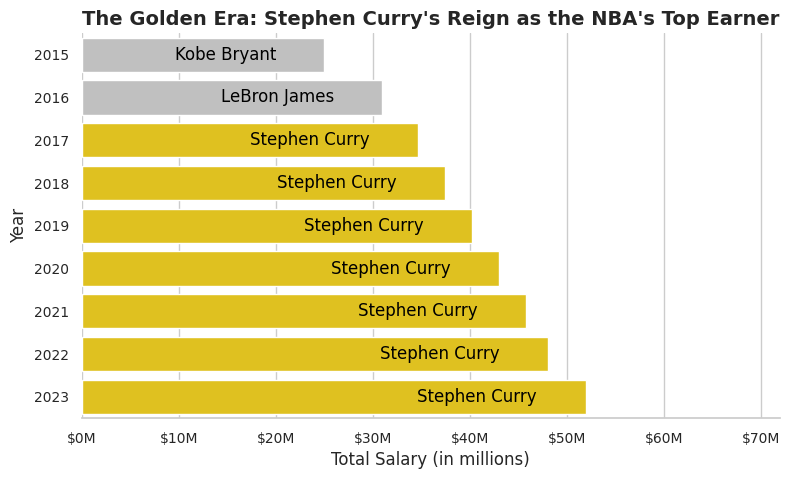

In [ ]:
bar_colors = highest_paid_each_year['player'].apply(lambda x: 'gold' if x == 'Stephen Curry' else 'silver').tolist()


sns.set_style("whitegrid")


plt.figure(figsize=(9, 5))

barplot = sns.barplot(
    x='salary_in_millions',
    y='year',
    data=highest_paid_each_year,
    orient='h',
    palette=bar_colors
)


for index, row in highest_paid_each_year.iterrows():
    plt.text(
        x=row['salary_in_millions'] - 5,
        y=index,
        s=row['player'],
        color='black',
        va='center',
        ha='right'
    )


ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}M'))


plt.title("The Golden Era: Stephen Curry's Reign as the NBA's Top Earner", fontsize=14, weight='bold')
plt.xlabel('Total Salary (in millions)', fontsize=12)
plt.ylabel('Year', fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.xlim(0, highest_paid_each_year['salary_in_millions'].max() + 20)


sns.despine(left=True)


plt.show()


### Top 5 players Rise Over time

In [ ]:
top_10_paid_players_df

Player  Total Salary  Total Salary in Millions
0    LeBron James   332793115.0                332.793115
1   Stephen Curry   324627564.0                324.627564
2    James Harden   293533321.0                293.533321
3     Paul George   280794214.0                280.794214
4    Kevin Durant   277409078.0                277.409078
5      Chris Paul   274125927.0                274.125927
6  Damian Lillard   271602207.0                271.602207
7    Jimmy Butler   258472814.0                258.472814
8   Anthony Davis   252174428.0                252.174428
9    Kyrie Irving   249761022.0                249.761022

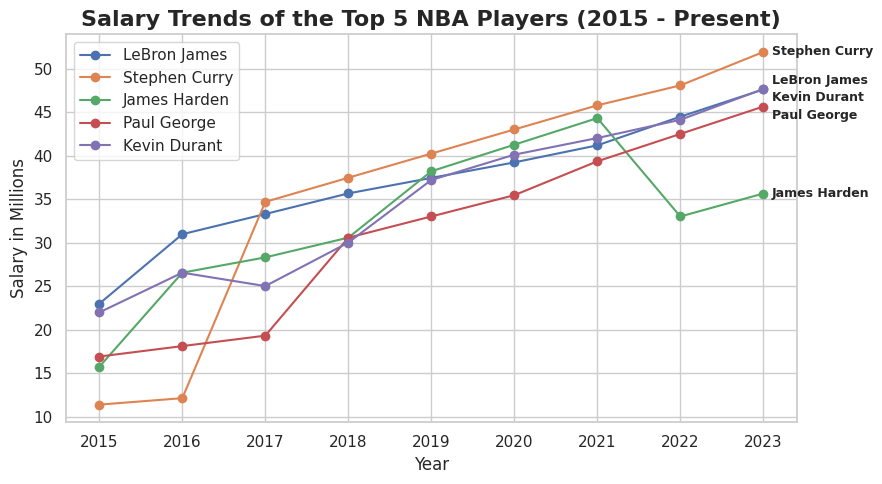

In [ ]:
temp_finaldata = finaldata.copy()
if not ((temp_finaldata['year'] == 2019) & (temp_finaldata['player'] == 'Kevin Durant')).any():
    kd_2019_data = pd.DataFrame([{'player': 'Kevin Durant', 'salary': 37199000, 'year': 2019}])
    temp_finaldata = pd.concat([temp_finaldata, kd_2019_data], ignore_index=True)


top_players = top_10_paid_players_df['Player'].head(5).to_list()
if 'Kevin Durant' not in top_players:
    top_players.append('Kevin Durant')

filtered_temp_data = temp_finaldata[temp_finaldata['player'].isin(top_players)]


pivot_temp_df = filtered_temp_data.pivot(index='year', columns='player', values='salary')


sns.set_style("whitegrid")


plt.figure(figsize=(9, 5))


for player in top_players:
    plt.plot(pivot_temp_df.index, pivot_temp_df[player] / 1e6, marker='o', label=player)


    last_salary = pivot_temp_df[player].dropna().iloc[-1] / 1e6
    last_year = pivot_temp_df[player].dropna().index[-1]
    text_x_position = last_year + 0.1
    text_y_position = last_salary


    if player == 'Kevin Durant':
        text_y_position -= 1
    elif player == 'Paul George':
        text_y_position -= 1
    elif player == 'LeBron James':
        text_y_position += 1

    plt.text(text_x_position, text_y_position, player, fontsize=9, weight='bold', va='center')


plt.title('Salary Trends of the Top 5 NBA Players (2015 - Present)', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Salary in Millions', fontsize=12)

plt.grid(True)


plt.legend()


plt.tight_layout()


plt.show()


### Top 10 Players with Most Fouls

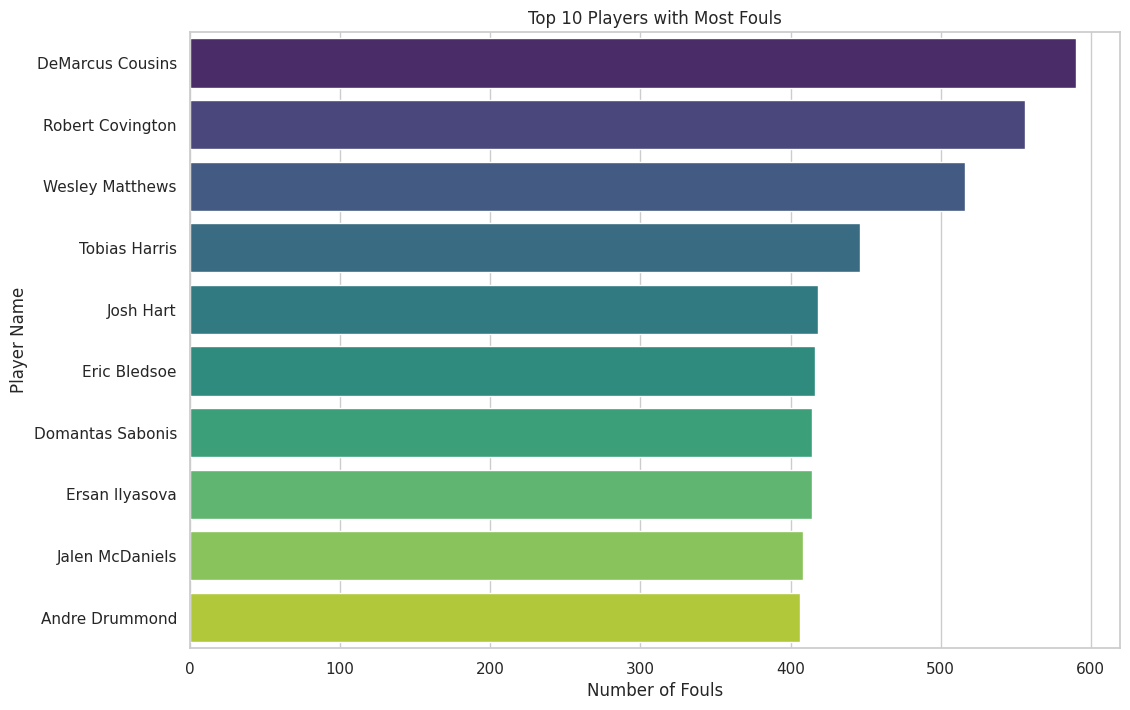

In [ ]:
mostfoul10 = finaldata.sort_values(by='pFouls', ascending=False).head(10)


plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='pFouls', y='player', data=mostfoul10, palette='viridis')
bar_plot.set_title('Top 10 Players with Most Fouls')
bar_plot.set_xlabel('Number of Fouls')
bar_plot.set_ylabel('Player Name')

plt.show()

### Players with high Rebounds

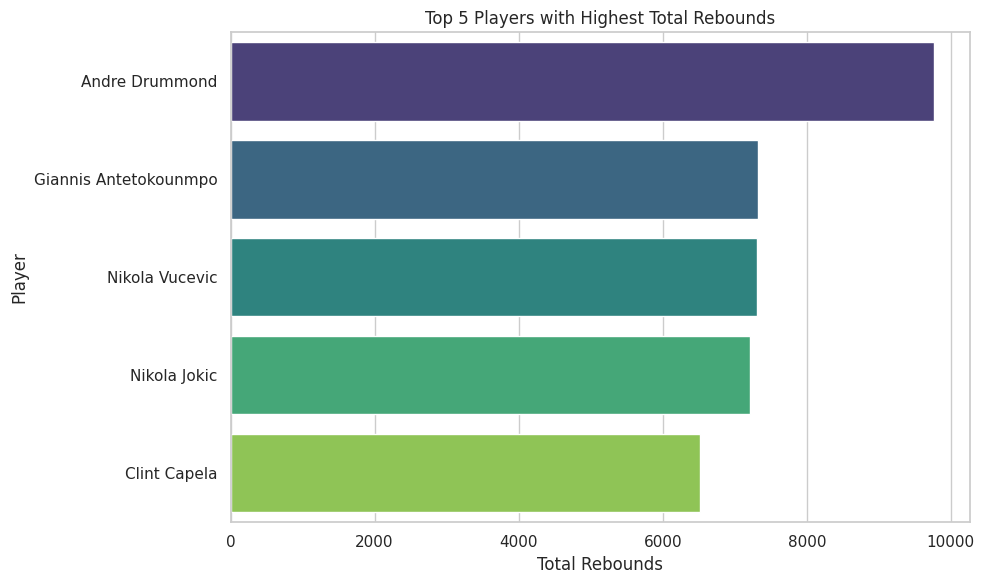

In [ ]:
top_rebounds_players = final_data.groupby('player')['totReb'].sum().reset_index().nlargest(5, 'totReb')


fig, ax = plt.subplots(figsize=(10, 6))



sns.barplot(x='totReb', y='player', data=top_rebounds_players, palette='viridis', ax=ax)


ax.set_xlabel('Total Rebounds')
ax.set_ylabel('Player')
ax.set_title('Top 5 Players with Highest Total Rebounds')


plt.tight_layout()
plt.show()



###Trends in Average NBA Salary: The COVID-19 Impact

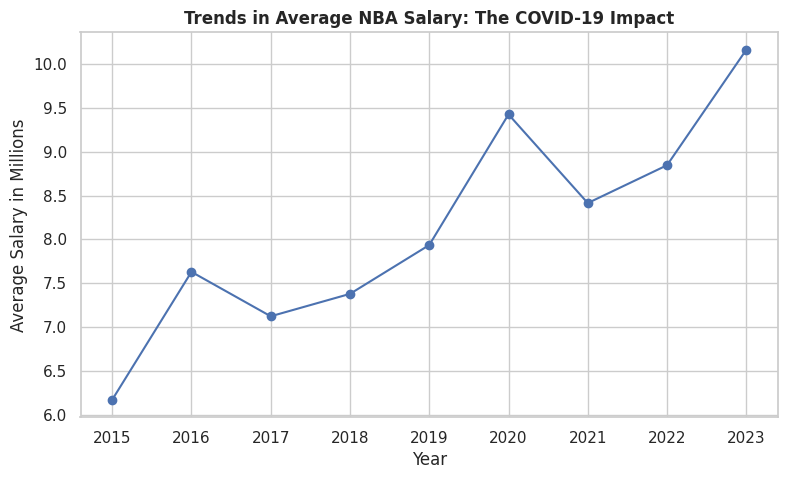


The graph above depicts a trend analysis of average NBA salaries over time, revealing a significant
downward adjustment in salaries after the 2020 season. This decline coincides with the global outbreak
of COVID-19, which had a profound impact on sports economics. The pandemic led to reduced revenues
from ticket sales and sponsorships, prompting salary reductions. This visualization captures the
pandemic's financial repercussions on NBA players' earnings.



In [ ]:
average_stats_over_time = finaldata.groupby('year').mean(numeric_only=True)

plt.figure(figsize=(9, 5))
plt.plot(average_stats_over_time.index, average_stats_over_time['salary'] / 1e6, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Salary in Millions')
plt.title('Trends in Average NBA Salary: The COVID-19 Impact', weight='bold')
plt.grid(True)


plt.show()

caption = """
The graph above depicts a trend analysis of average NBA salaries over time, revealing a significant
downward adjustment in salaries after the 2020 season. This decline coincides with the global outbreak
of COVID-19, which had a profound impact on sports economics. The pandemic led to reduced revenues
from ticket sales and sponsorships, prompting salary reductions. This visualization captures the
pandemic's financial repercussions on NBA players' earnings.
"""

print(caption)

##Normaization of data

In [ ]:
finaldata.describe().round(3)

year       fga       fgm  fg_accuracy       tpa       tpm  \
count  2933.000  2933.000  2933.000     2933.000  2933.000  2933.000   
mean   2019.248   403.098   186.378       44.992   144.586    52.326   
std       2.559   461.506   216.953        8.536   186.440    70.420   
min    2015.000     2.000     0.000        0.000     1.000     0.000   
25%    2017.000    63.000    28.000       40.586    18.000     5.000   
50%    2019.000   204.000    92.000       44.615    63.000    22.000   
75%    2022.000   616.000   275.000       49.254   205.000    72.000   
max    2023.000  2970.000  1414.000      100.000  1305.000   503.000   

       tp_accuracy       fta       ftm  ft_accuracy  ...    defReb    totReb  \
count     2933.000  2933.000  2933.000     2933.000  ...  2933.000  2933.000   
mean        32.753   107.782    84.360       76.483  ...   150.912   193.109   
std         13.820   153.340   123.444       15.294  ...   179.090   230.561   
min          0.000     1.000     0.000        0.000  ...     0.000     0.000   
25%         28.571    13.000     9.000       70.000  ...    25.000    32.000   
50%         34.509    42.000    32.000       78.613  ...    78.000    99.000   
75%         38.980   140.000   108.000       85.577  ...   222.000   280.000   
max        100.000  1386.000  1082.000      100.000  ...  1428.000  1794.000   

       turnovers    pFouls   assists    steals  plusMinus    blocks    points  \
count   2933.000  2933.000  2933.000  2933.000   2933.000  2933.000  2933.000   
mean      63.163    83.018   113.915    34.001      8.874    20.753   509.443   
std       76.858    81.100   158.126    38.683    177.905    30.608   603.332   
min        0.000     0.000     0.000     0.000   -892.000     0.000     1.000   
25%       10.000    18.000    15.000     6.000    -57.000     3.000    76.000   
50%       32.000    52.000    52.000    19.000     -6.000     9.000   246.000   
75%       91.000   135.000   143.000    50.000     48.000    26.000   750.000   
max      694.000   590.000  1584.000   328.000   1381.000   221.000  4064.000   

             salary  
count  2.933000e+03  
mean   8.188999e+06  
std    9.500063e+06  
min    5.849000e+03  
25%    1.719864e+06  
50%    4.033440e+06  
75%    1.160823e+07  
max    5.191562e+07  

[8 rows x 21 columns]

In [ ]:

columns_to_normalize = ['fga', 'fgm', 'fg_accuracy', 'tpa', 'tpm',
       'tp_accuracy', 'fta', 'ftm', 'ft_accuracy', 'offReb', 'defReb',
       'totReb', 'turnovers', 'pFouls', 'assists', 'steals', 'plusMinus',
       'blocks', 'points','salary']


min_max_scaler = MinMaxScaler()

finaldata[columns_to_normalize] = min_max_scaler.fit_transform(finaldata[columns_to_normalize])


<ipython-input-65-2a0d69f15431>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldata[columns_to_normalize] = min_max_scaler.fit_transform(finaldata[columns_to_normalize])


In [ ]:
finaldata.describe().round(3)

year       fga       fgm  fg_accuracy       tpa       tpm  \
count  2933.000  2933.000  2933.000     2933.000  2933.000  2933.000   
mean   2019.248     0.135     0.132        0.450     0.110     0.104   
std       2.559     0.155     0.153        0.085     0.143     0.140   
min    2015.000     0.000     0.000        0.000     0.000     0.000   
25%    2017.000     0.021     0.020        0.406     0.013     0.010   
50%    2019.000     0.068     0.065        0.446     0.048     0.044   
75%    2022.000     0.207     0.194        0.493     0.156     0.143   
max    2023.000     1.000     1.000        1.000     1.000     1.000   

       tp_accuracy       fta       ftm  ft_accuracy  ...    defReb    totReb  \
count     2933.000  2933.000  2933.000     2933.000  ...  2933.000  2933.000   
mean         0.328     0.077     0.078        0.765  ...     0.106     0.108   
std          0.138     0.111     0.114        0.153  ...     0.125     0.129   
min          0.000     0.000     0.000        0.000  ...     0.000     0.000   
25%          0.286     0.009     0.008        0.700  ...     0.018     0.018   
50%          0.345     0.030     0.030        0.786  ...     0.055     0.055   
75%          0.390     0.100     0.100        0.856  ...     0.155     0.156   
max          1.000     1.000     1.000        1.000  ...     1.000     1.000   

       turnovers    pFouls   assists    steals  plusMinus    blocks    points  \
count   2933.000  2933.000  2933.000  2933.000   2933.000  2933.000  2933.000   
mean       0.091     0.141     0.072     0.104      0.396     0.094     0.125   
std        0.111     0.137     0.100     0.118      0.078     0.138     0.148   
min        0.000     0.000     0.000     0.000      0.000     0.000     0.000   
25%        0.014     0.031     0.009     0.018      0.367     0.014     0.018   
50%        0.046     0.088     0.033     0.058      0.390     0.041     0.060   
75%        0.131     0.229     0.090     0.152      0.414     0.118     0.184   
max        1.000     1.000     1.000     1.000      1.000     1.000     1.000   

         salary  
count  2933.000  
mean      0.158  
std       0.183  
min       0.000  
25%       0.033  
50%       0.078  
75%       0.224  
max       1.000  

[8 rows x 21 columns]

In [ ]:
finaldata.head()

player  year       fga       fgm  fg_accuracy       tpa  \
0         Quincy Acy  2015  0.039084  0.051627     0.618644  0.018405   
1       Steven Adams  2015  0.189353  0.246110     0.617021  0.000000   
2      Arron Afflalo  2015  0.230458  0.222065     0.457726  0.157209   
5  LaMarcus Aldridge  2015  0.426213  0.458274     0.511444  0.013804   
7         Tony Allen  2015  0.152965  0.148515     0.460526  0.033742   

        tpm  tp_accuracy       fta       ftm  ...    defReb    totReb  \
0  0.021869     0.440000  0.023827  0.024954  ...  0.050420  0.055184   
1  0.000000     0.000000  0.208664  0.159889  ...  0.310224  0.413043   
2  0.161034     0.393204  0.078700  0.089649  ...  0.145658  0.125975   
5  0.003976     0.105263  0.263538  0.290203  ...  0.376050  0.413601   
7  0.027833     0.311111  0.096029  0.084104  ...  0.126751  0.152174   

   turnovers    pFouls   assists    steals  plusMinus    blocks    points  \
0   0.020173  0.110169  0.010732  0.045732   0.355037  0.063348  0.045041   
1   0.164265  0.494915  0.051768  0.161585   0.634844  0.488688  0.213635   
2   0.096542  0.213559  0.071970  0.070122   0.365596  0.040724  0.198129   
5   0.167147  0.305085  0.077652  0.137195   0.642323  0.438914  0.396505   
7   0.102305  0.277966  0.042298  0.320122   0.344919  0.072398  0.128969   

     salary  
0  0.018792  
1  0.043791  
2  0.154001  
5  0.379180  
7  0.096208  

[5 rows x 22 columns]

# **Machine Learning**

 * The Data has been preprocess and normalized so this part is
skipped (We are starting with a clean dataset)

In [ ]:
normalized_final_data = finaldata.copy()
df = normalized_final_data
df.columns

Index(['player', 'year', 'fga', 'fgm', 'fg_accuracy', 'tpa', 'tpm',
       'tp_accuracy', 'fta', 'ftm', 'ft_accuracy', 'offReb', 'defReb',
       'totReb', 'turnovers', 'pFouls', 'assists', 'steals', 'plusMinus',
       'blocks', 'points', 'salary'],
      dtype='object')

In [ ]:
df.head()

player  year       fga       fgm  fg_accuracy       tpa  \
0         Quincy Acy  2015  0.039084  0.051627     0.618644  0.018405   
1       Steven Adams  2015  0.189353  0.246110     0.617021  0.000000   
2      Arron Afflalo  2015  0.230458  0.222065     0.457726  0.157209   
5  LaMarcus Aldridge  2015  0.426213  0.458274     0.511444  0.013804   
7         Tony Allen  2015  0.152965  0.148515     0.460526  0.033742   

        tpm  tp_accuracy       fta       ftm  ...    defReb    totReb  \
0  0.021869     0.440000  0.023827  0.024954  ...  0.050420  0.055184   
1  0.000000     0.000000  0.208664  0.159889  ...  0.310224  0.413043   
2  0.161034     0.393204  0.078700  0.089649  ...  0.145658  0.125975   
5  0.003976     0.105263  0.263538  0.290203  ...  0.376050  0.413601   
7  0.027833     0.311111  0.096029  0.084104  ...  0.126751  0.152174   

   turnovers    pFouls   assists    steals  plusMinus    blocks    points  \
0   0.020173  0.110169  0.010732  0.045732   0.355037  0.063348  0.045041   
1   0.164265  0.494915  0.051768  0.161585   0.634844  0.488688  0.213635   
2   0.096542  0.213559  0.071970  0.070122   0.365596  0.040724  0.198129   
5   0.167147  0.305085  0.077652  0.137195   0.642323  0.438914  0.396505   
7   0.102305  0.277966  0.042298  0.320122   0.344919  0.072398  0.128969   

     salary  
0  0.018792  
1  0.043791  
2  0.154001  
5  0.379180  
7  0.096208  

[5 rows x 22 columns]

In [ ]:
df.select_dtypes(exclude=[np.number]).isna().sum()
df.isna().sum()

player         0
year           0
fga            0
fgm            0
fg_accuracy    0
tpa            0
tpm            0
tp_accuracy    0
fta            0
ftm            0
ft_accuracy    0
offReb         0
defReb         0
totReb         0
turnovers      0
pFouls         0
assists        0
steals         0
plusMinus      0
blocks         0
points         0
salary         0
dtype: int64

In [ ]:
df.drop(columns=['player', 'year'], inplace=True)

In [ ]:
df.head()

fga       fgm  fg_accuracy       tpa       tpm  tp_accuracy       fta  \
0  0.039084  0.051627     0.618644  0.018405  0.021869     0.440000  0.023827   
1  0.189353  0.246110     0.617021  0.000000  0.000000     0.000000  0.208664   
2  0.230458  0.222065     0.457726  0.157209  0.161034     0.393204  0.078700   
5  0.426213  0.458274     0.511444  0.013804  0.003976     0.105263  0.263538   
7  0.152965  0.148515     0.460526  0.033742  0.027833     0.311111  0.096029   

        ftm  ft_accuracy    offReb    defReb    totReb  turnovers    pFouls  \
0  0.024954     0.794118  0.051331  0.050420  0.055184   0.020173  0.110169   
1  0.159889     0.596552  0.566540  0.310224  0.413043   0.164265  0.494915   
2  0.089649     0.881818  0.034221  0.145658  0.125975   0.096542  0.213559   
5  0.290203     0.857923  0.389734  0.376050  0.413601   0.167147  0.305085   
7  0.084104     0.679104  0.174905  0.126751  0.152174   0.102305  0.277966   

    assists    steals  plusMinus    blocks    points    salary  
0  0.010732  0.045732   0.355037  0.063348  0.045041  0.018792  
1  0.051768  0.161585   0.634844  0.488688  0.213635  0.043791  
2  0.071970  0.070122   0.365596  0.040724  0.198129  0.154001  
5  0.077652  0.137195   0.642323  0.438914  0.396505  0.379180  
7  0.042298  0.320122   0.344919  0.072398  0.128969  0.096208

In [ ]:
target = "salary"

feature_names = [col for col in df if col != target]

X = df[feature_names]
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

print("TRAIN:", X_train.shape, y_train.shape)
print("TEST:", X_test.shape, y_test.shape)

TRAIN: (2346, 19) (2346,)
TEST: (587, 19) (587,)


## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 0.022226597135889405
R² Score: 0.3464549304474067


In [ ]:
coefs = Series(model.coef_, index=X_train.columns)


sorted_coefs = coefs.sort_values(ascending=False)

print(sorted_coefs)

tpa            0.857737
fgm            0.510179
assists        0.444971
points         0.296283
defReb         0.266362
plusMinus      0.243418
totReb         0.187438
blocks         0.109646
fg_accuracy    0.099722
ftm            0.093958
ft_accuracy    0.038415
tp_accuracy    0.006593
fta           -0.025285
offReb        -0.083842
turnovers     -0.200758
steals        -0.202048
fga           -0.339013
pFouls        -0.494347
tpm           -0.677238
dtype: float64


## L1 Regularization

Best alpha: 0.0001
Best R2 Score: 0.349899870073206
MSE with best alpha: 0.022109437220242698


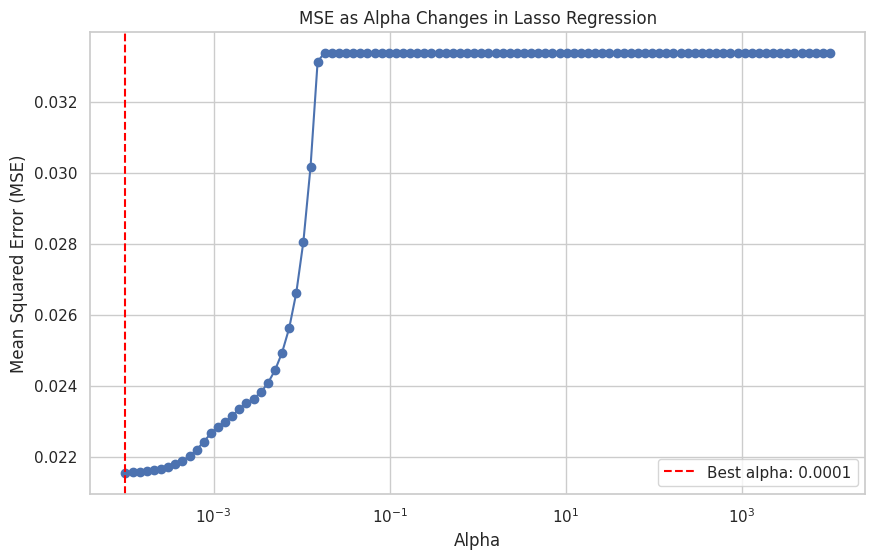

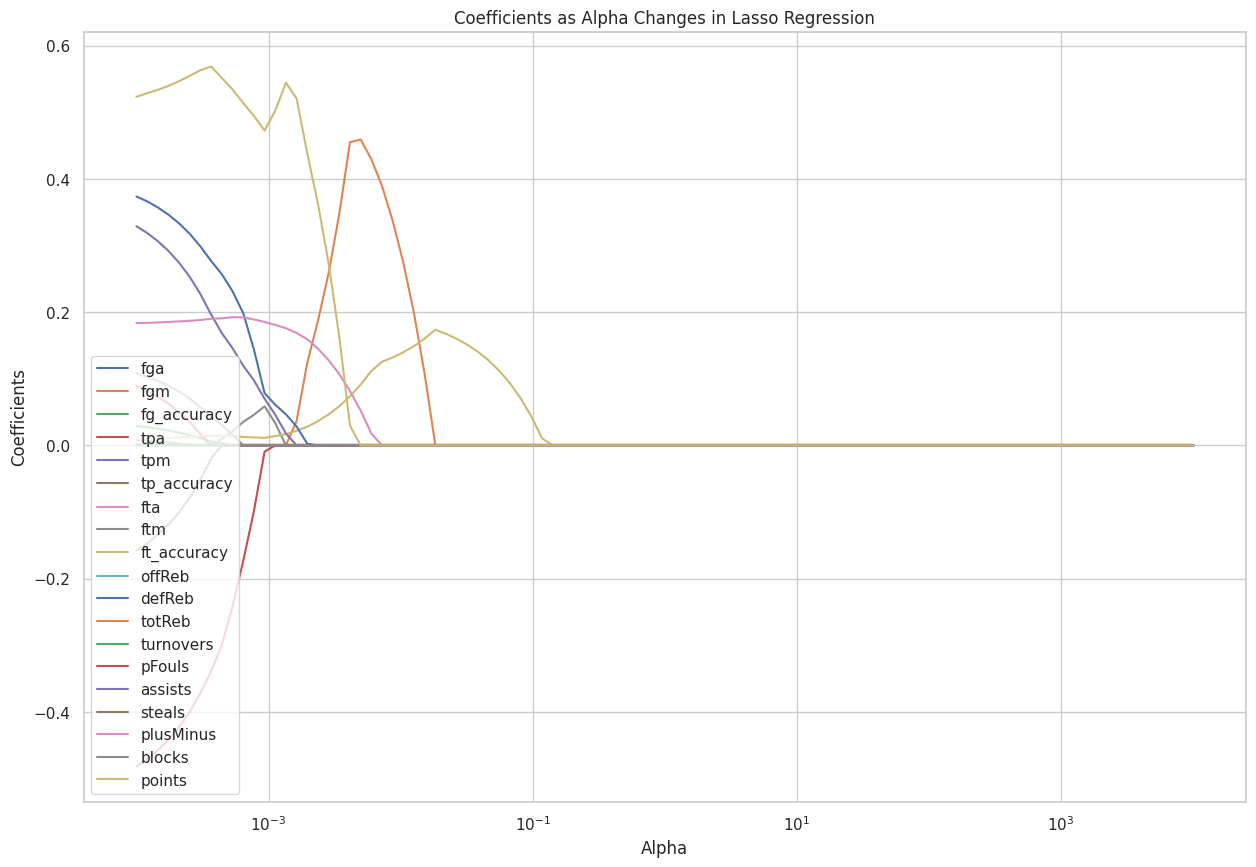

In [ ]:

alphas = np.logspace(-4, 4, 100)


lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train, y_train)

y_pred_best = lasso_cv.predict(X_test)


mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)


print(f'Best alpha: {lasso_cv.alpha_}')
print(f'Best R2 Score: {r2_best}')
print(f'MSE with best alpha: {mse_best}')

mse_list = np.mean(lasso_cv.mse_path_, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.alphas_, mse_list, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE as Alpha Changes in Lasso Regression')
plt.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', label=f'Best alpha: {lasso_cv.alpha_}')
plt.legend()
plt.show()


coefs_list = lasso_cv.path(X_train, y_train, alphas=alphas)[1].T


plt.figure(figsize=(15, 10))
for i in range(coefs_list.shape[1]):
    plt.plot(lasso_cv.alphas_, coefs_list[:, i], label=X_train.columns[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Coefficients as Alpha Changes in Lasso Regression')
plt.legend(loc='best')
plt.show()

* Try a PCA with L1 Regression

In [ ]:

n_components = 10


pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('lasso_cv', LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, max_iter=10000, random_state=99))
])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


best_alpha = pipeline.named_steps['lasso_cv'].alpha_


print(f'Best alpha: {best_alpha}')
print(f'R² Score: {r2}')
print(f'MSE: {mse}')

Best alpha: 0.0001
R² Score: 0.3416136062664836
MSE: 0.022391247084587333


## L2 Regularization

Best lambda (alpha): 0.24770763559917114
Best R2 Score (Ridge): 0.34980479145921806
MSE with best lambda (Ridge): 0.02211267077542933


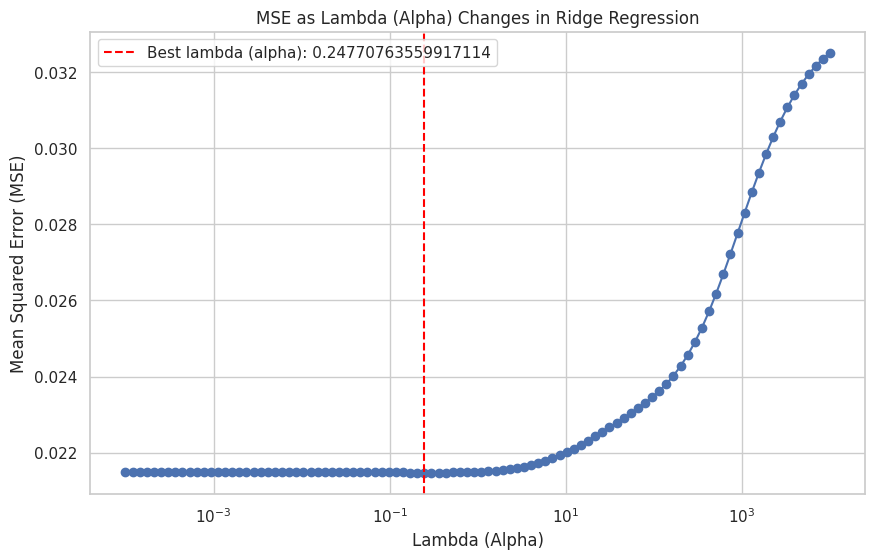

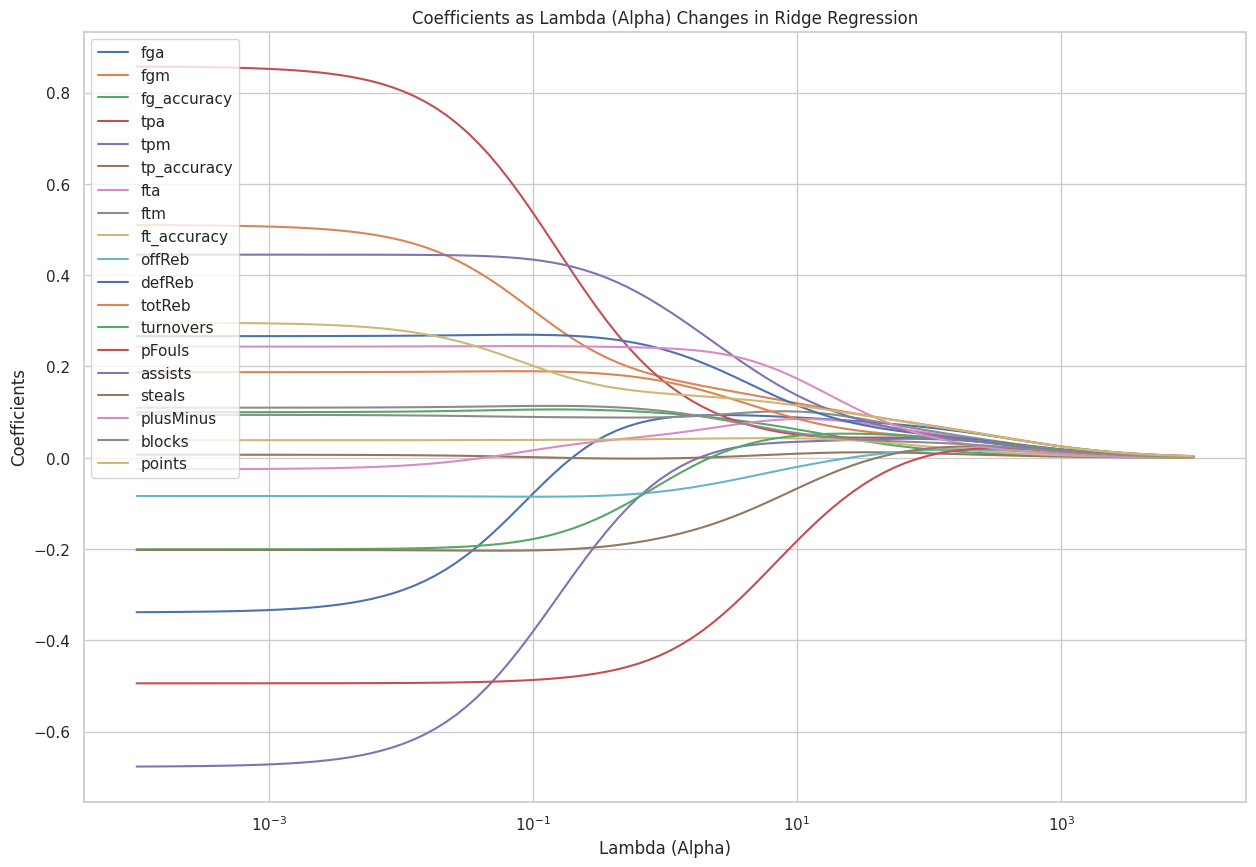

In [ ]:

lambdas = np.logspace(-4, 4, 100)


ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)


y_pred_best_ridge = ridge_cv.predict(X_test)


mse_best_ridge = mean_squared_error(y_test, y_pred_best_ridge)
r2_best_ridge = r2_score(y_test, y_pred_best_ridge)

print(f'Best lambda (alpha): {ridge_cv.alpha_}')
print(f'Best R2 Score (Ridge): {r2_best_ridge}')
print(f'MSE with best lambda (Ridge): {mse_best_ridge}')

mse_list_ridge = ridge_cv.cv_values_.mean(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_list_ridge, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE as Lambda (Alpha) Changes in Ridge Regression')
plt.axvline(x=ridge_cv.alpha_, color='red', linestyle='--', label=f'Best lambda (alpha): {ridge_cv.alpha_}')
plt.legend()
plt.show()


ridge_coefs_list = []


for lambda_ in lambdas:
    ridge = Ridge(alpha=lambda_)
    ridge.fit(X_train, y_train)
    ridge_coefs_list.append(ridge.coef_)

ridge_coefs_list = np.array(ridge_coefs_list)


plt.figure(figsize=(15, 10))

for i in range(ridge_coefs_list.shape[1]):
    plt.plot(lambdas, ridge_coefs_list[:, i], label=X_train.columns[i])

plt.xscale('log')
plt.xlabel('Lambda (Alpha)')
plt.ylabel('Coefficients')
plt.title('Coefficients as Lambda (Alpha) Changes in Ridge Regression')
plt.legend(loc='best')
plt.show()

* Try PCA with L2 Regularization

In [ ]:
n_components = 10
lambdas = np.logspace(-4, 4, 100)

pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('ridge_cv', RidgeCV(alphas=lambdas, store_cv_values=True))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

best_lambda = pipeline.named_steps['ridge_cv'].alpha_

print(f'Best lambda (alpha): {best_lambda}')
print(f'R² Score: {r2}')
print(f'MSE: {mse}')

Best lambda (alpha): 0.298364724028334
R² Score: 0.3396446618356166
MSE: 0.022458209466658077


## Random Forrest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R² Score:", r2_rf)

feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

Random Forest - Mean Squared Error: 0.018943928808413068
Random Forest - R² Score: 0.44297765442904913
             importance
ftm            0.224810
pFouls         0.092888
points         0.077288
plusMinus      0.074388
fta            0.058886
assists        0.054267
ft_accuracy    0.047467
fgm            0.041001
fga            0.036303
defReb         0.033987
fg_accuracy    0.033656
turnovers      0.032158
steals         0.030879
offReb         0.028834
blocks         0.028504
tp_accuracy    0.027924
tpa            0.026971
totReb         0.026188
tpm            0.023603


* Introducing Hyperparmeter tuning using Gridsearch

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=99)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

y_pred_rf_best = best_rf_model.predict(X_test)


mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Random Forest - Best Mean Squared Error: {mse_rf_best}")
print(f"Random Forest - Best R² Score: {r2_rf_best}")

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
Best parameters found: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest - Best Mean Squared Error: 0.01882895444282222
Random Forest - Best R² Score: 0.4463583307105977


# XG Boost Model with Hyperparmeter Tuning

In [ ]:
from xgboost import XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0.01, 0.05, 0.1],
    'reg_lambda': [0.01, 0.05, 0.1]
}

xgb = XGBRegressor(random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb_best = best_xgb_model.predict(X_test)

mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

print(f"Best parameters found: {grid_search_xgb.best_params_}")
print(f"XGBoost - Best Mean Squared Error: {mse_xgb_best}")
print(f"XGBoost - Best R² Score: {r2_xgb_best}")


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.05, 'reg_lambda': 0.1, 'subsample': 0.8}
XGBoost - Best Mean Squared Error: 0.019090499142072552
XGBoost - Best R² Score: 0.4386679385368597


# Neural Network

In [ ]:
def NBAPlayerSalaryNet(input_dim=19, first_layer_neurons=5, second_layer_neurons=5,
                       first_layer_activation='relu', second_layer_activation='relu',
                       optimizer='adam', loss='mean_squared_error'):
    model = Sequential(name='NBAPlayerSalaryNet')


    model.add(Dense(units=first_layer_neurons, input_dim=input_dim,
                    kernel_initializer='normal', activation=first_layer_activation))


    model.add(Dense(units=second_layer_neurons, kernel_initializer='normal',
                    activation=second_layer_activation))


    model.add(Dense(1, kernel_initializer='normal', activation='relu'))


    model.compile(loss=loss, optimizer=optimizer)
    return model

model = NBAPlayerSalaryNet()
model.fit(X_train, y_train, batch_size=20, epochs=50, verbose=1)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Model Performance on Test Set - Mean Squared Error: {mse}")

Epoch 1/50
118/118 [==============================] - 1s 1ms/step - loss: 0.0387
Epoch 2/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 3/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0238
Epoch 4/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 5/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 6/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 7/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 8/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 9/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 10/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 11/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 12/50
118/118 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 13/50
118/118 [====

# SEI report using Random Forrest and XGBoost

In [ ]:
print("Shape of X_test:", X_test.shape)
print("Shape of df:", df.shape)
print("Shape of finaldata:", finaldata.shape)

Shape of X_test: (587, 19)
Shape of df: (2933, 20)
Shape of finaldata: (2933, 22)


In [ ]:
X_test.head()

fga       fgm  fg_accuracy       tpa       tpm  tp_accuracy  \
136  0.541779  0.650636     0.571429  0.206288  0.166998     0.311111   
183  0.004380  0.002829     0.266667  0.003834  0.001988     0.166667   
47   0.004380  0.002122     0.200000  0.003834  0.000000     0.000000   
33   0.373315  0.338048     0.430631  0.308282  0.312127     0.389578   
32   0.569407  0.517680     0.432624  0.867331  0.815109     0.362191   

          fta       ftm  ft_accuracy    offReb    defReb    totReb  turnovers  \
136  0.485921  0.460259     0.738872  0.783270  0.794118  0.861761   0.582133   
183  0.000722  0.001848     1.000000  0.001901  0.004902  0.004459   0.001441   
47   0.003610  0.005545     1.000000  0.000000  0.006303  0.005017   0.008646   
33   0.254152  0.288355     0.883853  0.060837  0.156863  0.142698   0.293948   
32   0.189892  0.197782     0.810606  0.307985  0.683473  0.634337   0.337176   

       pFouls   assists    steals  plusMinus    blocks    points  
136  0.701695  0.419192  0.378049   0.393313  0.253394  0.595865  
183  0.005085  0.011364  0.006098   0.383194  0.004525  0.002461  
47   0.000000  0.005682  0.000000   0.387154  0.000000  0.002707  
33   0.301695  0.172348  0.158537   0.229212  0.063348  0.350480  
32   0.942373  0.138889  0.896341   0.393313  0.995475  0.513660

In [ ]:
df.head()

fga       fgm  fg_accuracy       tpa       tpm  tp_accuracy       fta  \
0  0.039084  0.051627     0.618644  0.018405  0.021869     0.440000  0.023827   
1  0.189353  0.246110     0.617021  0.000000  0.000000     0.000000  0.208664   
2  0.230458  0.222065     0.457726  0.157209  0.161034     0.393204  0.078700   
5  0.426213  0.458274     0.511444  0.013804  0.003976     0.105263  0.263538   
7  0.152965  0.148515     0.460526  0.033742  0.027833     0.311111  0.096029   

        ftm  ft_accuracy    offReb    defReb    totReb  turnovers    pFouls  \
0  0.024954     0.794118  0.051331  0.050420  0.055184   0.020173  0.110169   
1  0.159889     0.596552  0.566540  0.310224  0.413043   0.164265  0.494915   
2  0.089649     0.881818  0.034221  0.145658  0.125975   0.096542  0.213559   
5  0.290203     0.857923  0.389734  0.376050  0.413601   0.167147  0.305085   
7  0.084104     0.679104  0.174905  0.126751  0.152174   0.102305  0.277966   

    assists    steals  plusMinus    blocks    points    salary  
0  0.010732  0.045732   0.355037  0.063348  0.045041  0.018792  
1  0.051768  0.161585   0.634844  0.488688  0.213635  0.043791  
2  0.071970  0.070122   0.365596  0.040724  0.198129  0.154001  
5  0.077652  0.137195   0.642323  0.438914  0.396505  0.379180  
7  0.042298  0.320122   0.344919  0.072398  0.128969  0.096208

In [ ]:
finaldata.head()

player  year       fga       fgm  fg_accuracy       tpa  \
0         Quincy Acy  2015  0.039084  0.051627     0.618644  0.018405   
1       Steven Adams  2015  0.189353  0.246110     0.617021  0.000000   
2      Arron Afflalo  2015  0.230458  0.222065     0.457726  0.157209   
5  LaMarcus Aldridge  2015  0.426213  0.458274     0.511444  0.013804   
7         Tony Allen  2015  0.152965  0.148515     0.460526  0.033742   

        tpm  tp_accuracy       fta       ftm  ...    defReb    totReb  \
0  0.021869     0.440000  0.023827  0.024954  ...  0.050420  0.055184   
1  0.000000     0.000000  0.208664  0.159889  ...  0.310224  0.413043   
2  0.161034     0.393204  0.078700  0.089649  ...  0.145658  0.125975   
5  0.003976     0.105263  0.263538  0.290203  ...  0.376050  0.413601   
7  0.027833     0.311111  0.096029  0.084104  ...  0.126751  0.152174   

   turnovers    pFouls   assists    steals  plusMinus    blocks    points  \
0   0.020173  0.110169  0.010732  0.045732   0.355037  0.063348  0.045041   
1   0.164265  0.494915  0.051768  0.161585   0.634844  0.488688  0.213635   
2   0.096542  0.213559  0.071970  0.070122   0.365596  0.040724  0.198129   
5   0.167147  0.305085  0.077652  0.137195   0.642323  0.438914  0.396505   
7   0.102305  0.277966  0.042298  0.320122   0.344919  0.072398  0.128969   

     salary  
0  0.018792  
1  0.043791  
2  0.154001  
5  0.379180  
7  0.096208  

[5 rows x 22 columns]

In [ ]:
df_copy = df.copy()
finaldata_copy = finaldata.copy()

In [ ]:
features_for_prediction = df_copy.drop(['salary'], axis=1)
features_for_prediction.head()

fga       fgm  fg_accuracy       tpa       tpm  tp_accuracy       fta  \
0  0.039084  0.051627     0.618644  0.018405  0.021869     0.440000  0.023827   
1  0.189353  0.246110     0.617021  0.000000  0.000000     0.000000  0.208664   
2  0.230458  0.222065     0.457726  0.157209  0.161034     0.393204  0.078700   
5  0.426213  0.458274     0.511444  0.013804  0.003976     0.105263  0.263538   
7  0.152965  0.148515     0.460526  0.033742  0.027833     0.311111  0.096029   

        ftm  ft_accuracy    offReb    defReb    totReb  turnovers    pFouls  \
0  0.024954     0.794118  0.051331  0.050420  0.055184   0.020173  0.110169   
1  0.159889     0.596552  0.566540  0.310224  0.413043   0.164265  0.494915   
2  0.089649     0.881818  0.034221  0.145658  0.125975   0.096542  0.213559   
5  0.290203     0.857923  0.389734  0.376050  0.413601   0.167147  0.305085   
7  0.084104     0.679104  0.174905  0.126751  0.152174   0.102305  0.277966   

    assists    steals  plusMinus    blocks    points  
0  0.010732  0.045732   0.355037  0.063348  0.045041  
1  0.051768  0.161585   0.634844  0.488688  0.213635  
2  0.071970  0.070122   0.365596  0.040724  0.198129  
5  0.077652  0.137195   0.642323  0.438914  0.396505  
7  0.042298  0.320122   0.344919  0.072398  0.128969

In [ ]:
predicted_salary_rf = best_rf_model.predict(features_for_prediction)
predicted_salary_xgb = best_xgb_model.predict(features_for_prediction)
predicted_salary_nn = model.predict(features_for_prediction)

92/92 [==============================] - 0s 874us/step


In [ ]:
temp_df_rf = features_for_prediction.copy()
temp_df_rf['salary'] = predicted_salary_rf

temp_df_xgb = features_for_prediction.copy()
temp_df_xgb['salary'] = predicted_salary_xgb

temp_df_nn = features_for_prediction.copy()
temp_df_nn['salary'] = predicted_salary_nn.flatten()

In [ ]:
finaldata_copy['Predicted Salary RF'] = temp_df_rf['salary']
finaldata_copy['Predicted Salary XGB'] = temp_df_xgb['salary']
finaldata_copy['Predicted Salary NN'] = temp_df_nn['salary']

finaldata_copy.head()

player  year       fga       fgm  fg_accuracy       tpa  \
0         Quincy Acy  2015  0.039084  0.051627     0.618644  0.018405   
1       Steven Adams  2015  0.189353  0.246110     0.617021  0.000000   
2      Arron Afflalo  2015  0.230458  0.222065     0.457726  0.157209   
5  LaMarcus Aldridge  2015  0.426213  0.458274     0.511444  0.013804   
7         Tony Allen  2015  0.152965  0.148515     0.460526  0.033742   

        tpm  tp_accuracy       fta       ftm  ...    pFouls   assists  \
0  0.021869     0.440000  0.023827  0.024954  ...  0.110169  0.010732   
1  0.000000     0.000000  0.208664  0.159889  ...  0.494915  0.051768   
2  0.161034     0.393204  0.078700  0.089649  ...  0.213559  0.071970   
5  0.003976     0.105263  0.263538  0.290203  ...  0.305085  0.077652   
7  0.027833     0.311111  0.096029  0.084104  ...  0.277966  0.042298   

     steals  plusMinus    blocks    points    salary  Predicted Salary RF  \
0  0.045732   0.355037  0.063348  0.045041  0.018792             0.043911   
1  0.161585   0.634844  0.488688  0.213635  0.043791             0.251678   
2  0.070122   0.365596  0.040724  0.198129  0.154001             0.192704   
5  0.137195   0.642323  0.438914  0.396505  0.379180             0.384120   
7  0.320122   0.344919  0.072398  0.128969  0.096208             0.092061   

   Predicted Salary XGB  Predicted Salary NN  
0              0.068974             0.061620  
1              0.189098             0.197960  
2              0.180882             0.227196  
5              0.380841             0.468116  
7              0.071184             0.095113  

[5 rows x 25 columns]

In [ ]:

finaldata_copy['SEI_RF'] = finaldata_copy['Predicted Salary RF'] / finaldata_copy['salary']
finaldata_copy['SEI_XGB'] = finaldata_copy['Predicted Salary XGB'] / finaldata_copy['salary']
finaldata_copy['SEI_NN'] = finaldata_copy['Predicted Salary NN'] / finaldata_copy['salary']


sei_report = finaldata_copy[['player', 'SEI_RF', 'SEI_XGB', 'SEI_NN']]
print(sei_report)

                player    SEI_RF   SEI_XGB    SEI_NN
0           Quincy Acy  2.336655  3.670375  3.279023
1         Steven Adams  5.747229  4.318173  4.520546
2        Arron Afflalo  1.251315  1.174550  1.475293
5    LaMarcus Aldridge  1.013027  1.004379  1.234548
7           Tony Allen  0.956891  0.739890  0.988616
..                 ...       ...       ...       ...
397        Kris Murray  1.253453  1.017803  1.098152
398         Duop Reath  3.700462  5.738983  7.137368
399        Colby Jones  1.501492  1.577681  1.616394
401     Sasha Vezenkov  0.691970  0.778296  0.744114
404  Victor Wembanyama  0.950309  1.364881  1.088297

[2933 rows x 4 columns]


In [ ]:
sei_rf_sorted = sei_report.sort_values(by='SEI_RF', ascending=False)

top_10_rf = sei_rf_sorted.head(10)

bottom_10_rf = sei_rf_sorted.tail(10)


print("Top 10 Players with Highest SEI_RF:")
print(top_10_rf[['player', 'SEI_RF']])

print("\nBottom 10 Players with Lowest SEI_RF:")
print(bottom_10_rf[['player', 'SEI_RF']])

Top 10 Players with Highest SEI_RF:
                player      SEI_RF
328       RaiQuan Gray         inf
432      Justin Minaya  185.772995
310       Kobi Simmons  167.918571
350     Zavier Simpson   94.251826
248  Mfiondu Kabengele   87.279920
136          RJ Hunter   82.974350
249          Gabe York   82.036067
301         Jay Scrubb   75.648337
405          Tre Scott   70.237331
170       Kobi Simmons   67.650504

Bottom 10 Players with Lowest SEI_RF:
              player    SEI_RF
136    Terrence Ross  0.216953
79      Jamal Murray  0.213090
56     Blake Griffin  0.169525
179  Cameron Johnson  0.162343
36      Goran Dragic  0.153716
159  Justise Winslow  0.152539
65      Gorgui Dieng  0.128830
8      Nicolas Batum  0.110917
116     Kelly Olynyk  0.107836
62         Luol Deng  0.104990


In [ ]:
sei_xgb_sorted = sei_report.sort_values(by='SEI_XGB', ascending=False)

top_10_xgb = sei_xgb_sorted.head(10)

bottom_10_xgb = sei_xgb_sorted.tail(10)


print("Top 10 Players with Highest SEI_XGB:")
print(top_10_xgb[['player', 'SEI_XGB']])

print("\nBottom 10 Players with Lowest SEI_XGB:")
print(bottom_10_xgb[['player', 'SEI_XGB']])

Top 10 Players with Highest SEI_XGB:
                player     SEI_XGB
328       RaiQuan Gray         inf
248  Mfiondu Kabengele  173.740204
310       Kobi Simmons  170.118043
432      Justin Minaya  125.138918
350     Zavier Simpson  121.697611
249          Gabe York  119.871548
253        Alex Caruso  111.791844
261  Jordan McLaughlin  104.720118
170       Kobi Simmons   96.412711
374     Mitchell Creek   96.063886

Bottom 10 Players with Lowest SEI_XGB:
               player   SEI_XGB
160   Anfernee Simons  0.174014
224  Chandler Parsons  0.171886
224       Evan Turner  0.170137
56      Blake Griffin  0.162541
131      Kemba Walker  0.160061
62          Luol Deng  0.151908
5        Bradley Beal  0.132768
96         Kevin Love  0.129170
122    Gordon Hayward  0.108874
8       Nicolas Batum  0.103107


In [ ]:
sei_nn_sorted = sei_report.sort_values(by='SEI_NN', ascending=False)


top_10_nn = sei_nn_sorted.head(10)

bottom_10_nn = sei_nn_sorted.tail(10)

print("Top 10 Players with Highest SEI_NN:")
print(top_10_nn[['player', 'SEI_NN']])

print("\nBottom 10 Players with Lowest SEI_NN:")
print(bottom_10_nn[['player', 'SEI_NN']])

Top 10 Players with Highest SEI_NN:
                player      SEI_NN
328       RaiQuan Gray         inf
248  Mfiondu Kabengele  273.285385
249          Gabe York  138.486024
170       Kobi Simmons  130.134257
350     Zavier Simpson  127.755758
310       Kobi Simmons  111.837820
324  Jaron Blossomgame  104.772579
133      Edmond Sumner  103.747509
377      Kendrick Nunn  103.583379
253        Alex Caruso   95.167933

Bottom 10 Players with Lowest SEI_NN:
               player    SEI_NN
118     Dillon Brooks  0.181297
34       Gorgui Dieng  0.179812
93      James Johnson  0.173215
160   Anfernee Simons  0.148357
189  Chandler Parsons  0.146111
96         Kevin Love  0.138674
8       Nicolas Batum  0.129620
131      Kemba Walker  0.121299
122    Gordon Hayward  0.111782
5        Bradley Beal  0.094296
